# Results and Analysis

In [1]:
%cd ..

C:\Users\Caitlin\Documents\Brett_TTT_projects\predicting_cust_churn


In [2]:
import pandas as pd
import joblib
import numpy as np
from collections import Counter
from itertools import combinations
from IPython.display import Image, display

In [3]:
cat_shap_fold_0 = pd.read_csv('cv_tuning_results/catboost_avg_shap_fold0.csv')
cat_shap_fold_1 = pd.read_csv('cv_tuning_results/catboost_avg_shap_fold1.csv')
cat_shap_fold_2 = pd.read_csv('cv_tuning_results/catboost_avg_shap_fold2.csv')

In [4]:
lgbm_shap_fold_0 = pd.read_csv('cv_tuning_results/lightgbm_avg_shap_fold0.csv')
lgbm_shap_fold_1 = pd.read_csv('cv_tuning_results/lightgbm_avg_shap_fold1.csv')
lgbm_shap_fold_2 = pd.read_csv('cv_tuning_results/lightgbm_avg_shap_fold2.csv')

In [5]:
xgb_shap_fold_0 = pd.read_csv('cv_tuning_results/xgboost_avg_shap_fold0.csv')
xgb_shap_fold_1 = pd.read_csv('cv_tuning_results/xgboost_avg_shap_fold1.csv')
xgb_shap_fold_2 = pd.read_csv('cv_tuning_results/xgboost_avg_shap_fold2.csv')

## Per Fold SHAP outputs 

### CatBoost

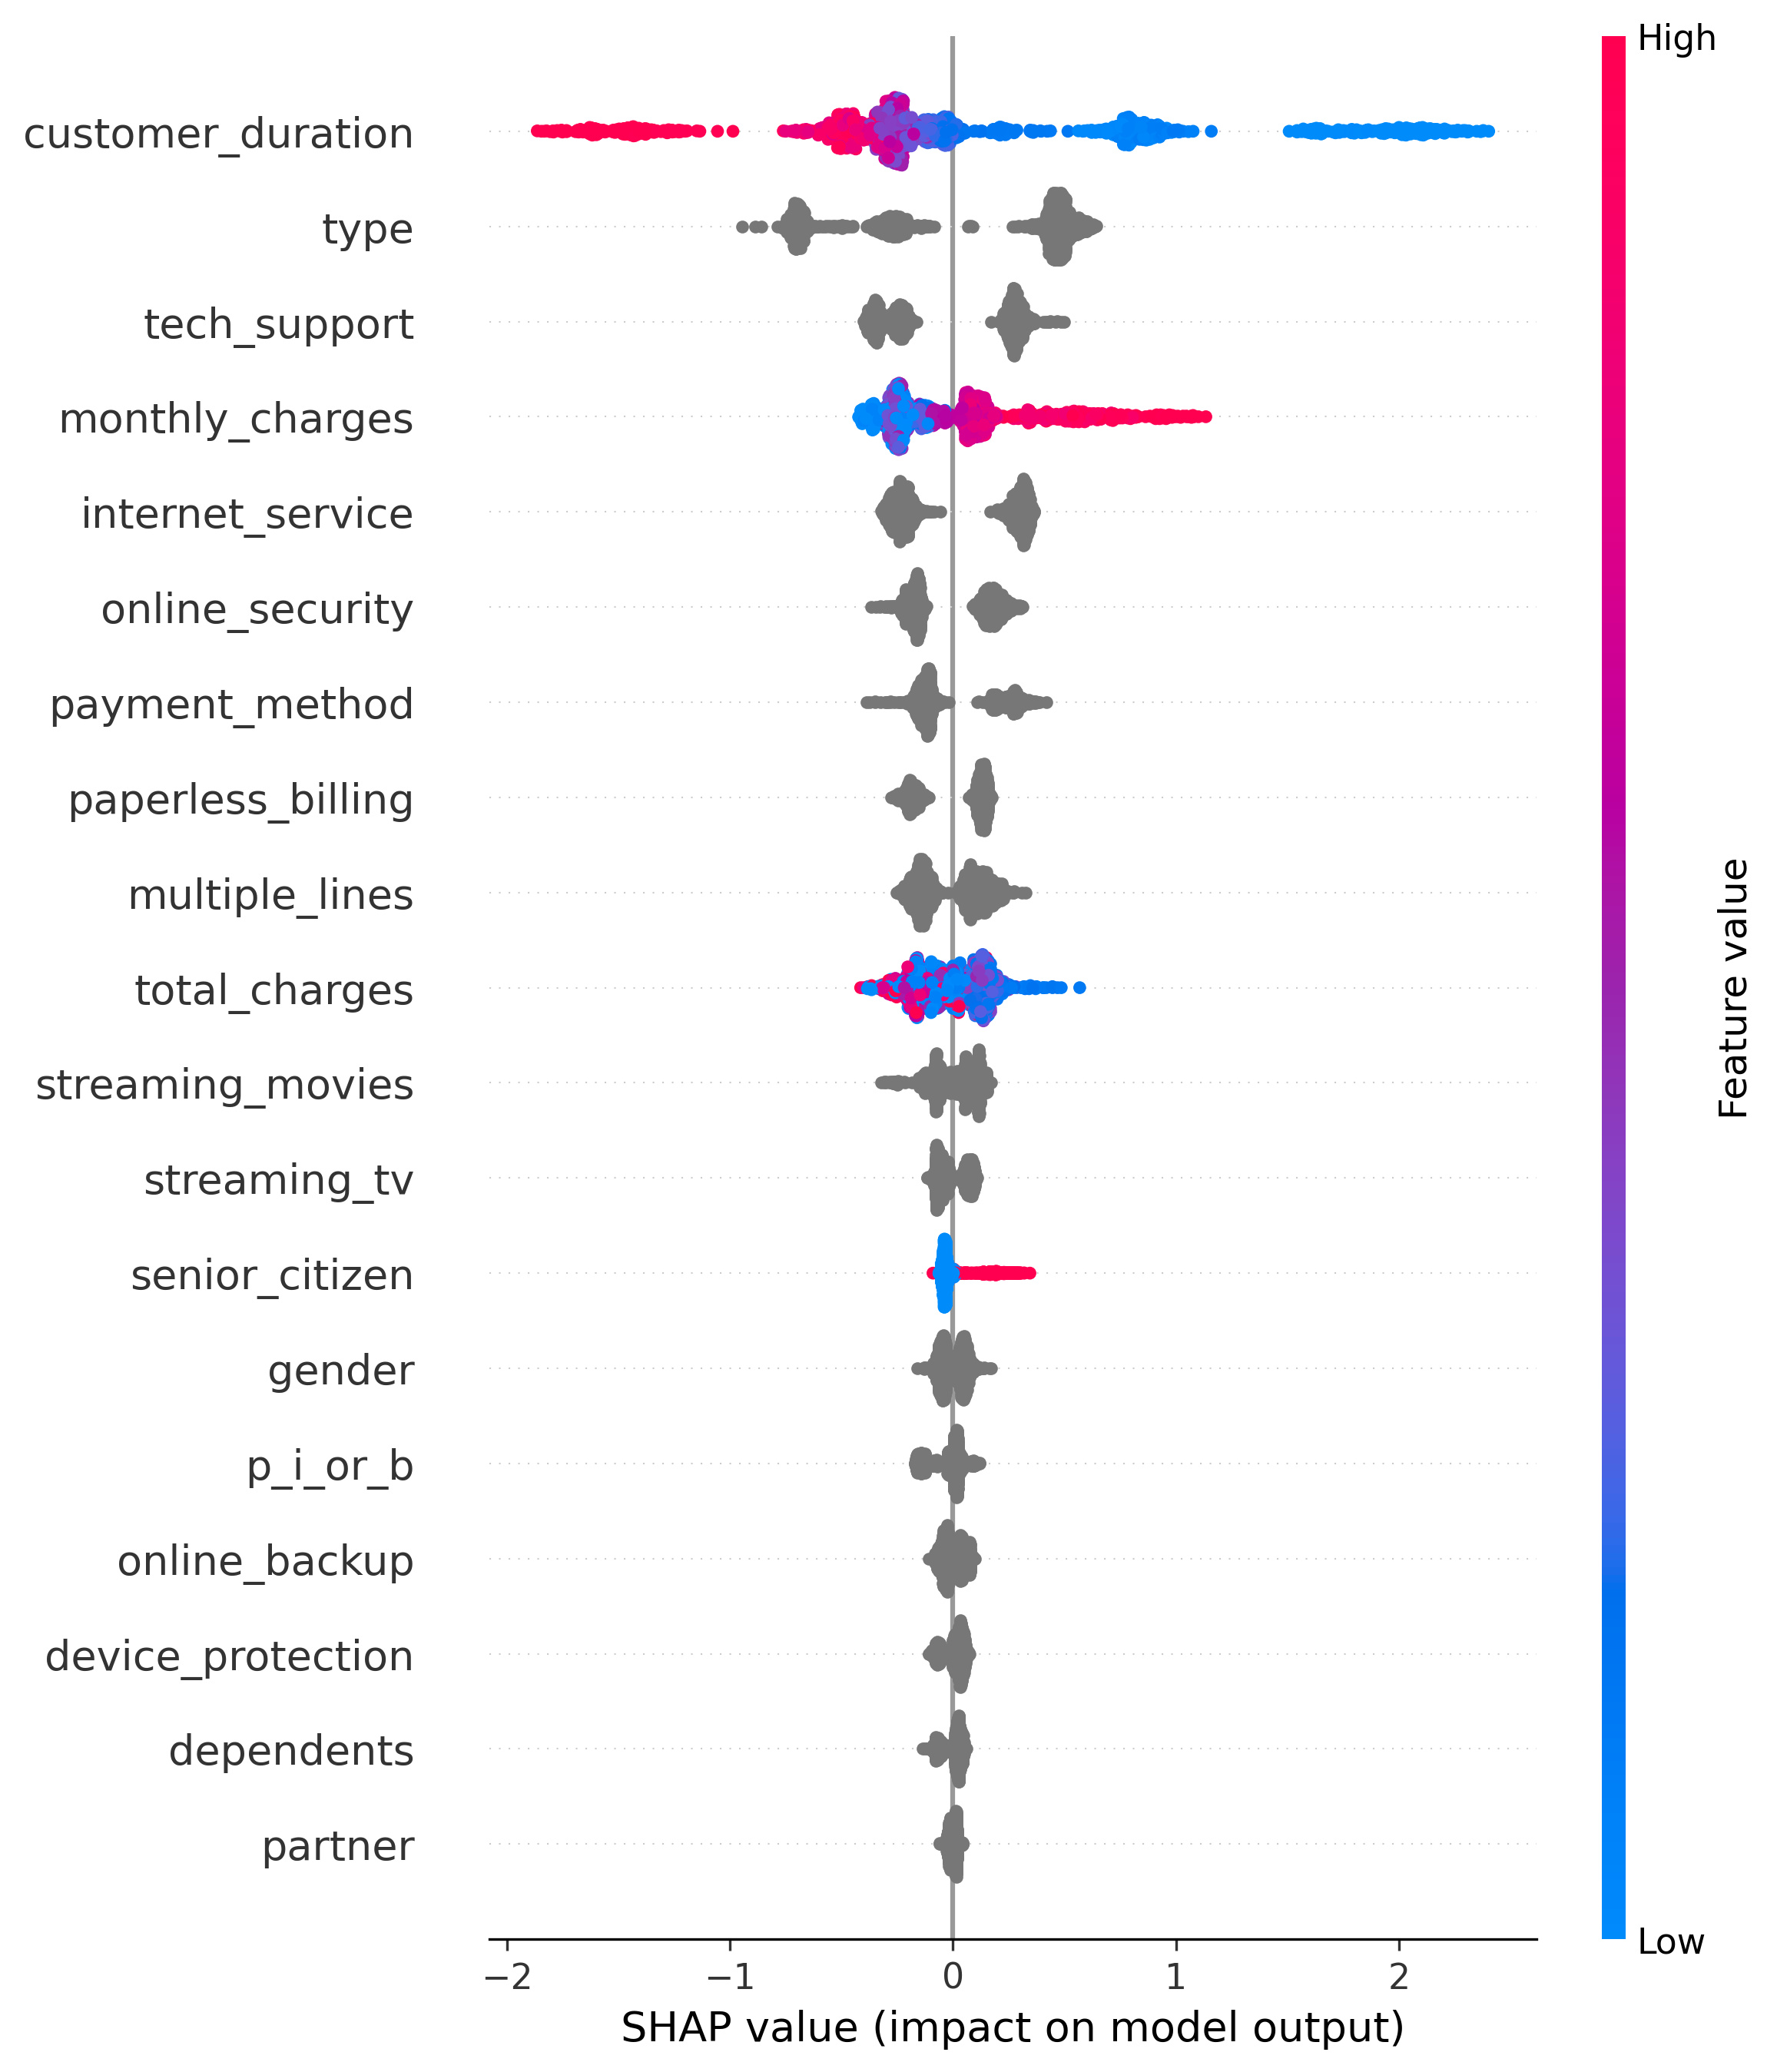

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.485182,0.153701,0.167975,0.264701,0.129093,0.049594,0.056854,0.01338,0.036352,0.045417,0.263396,0.179871,0.041658,0.036712,0.286028,0.060091,0.08118,0.131595,0.646185


In [6]:
display(Image(filename='cv_tuning_results/catboost_shap_summary_plot_fold0.png'))
cat_shap_fold_0

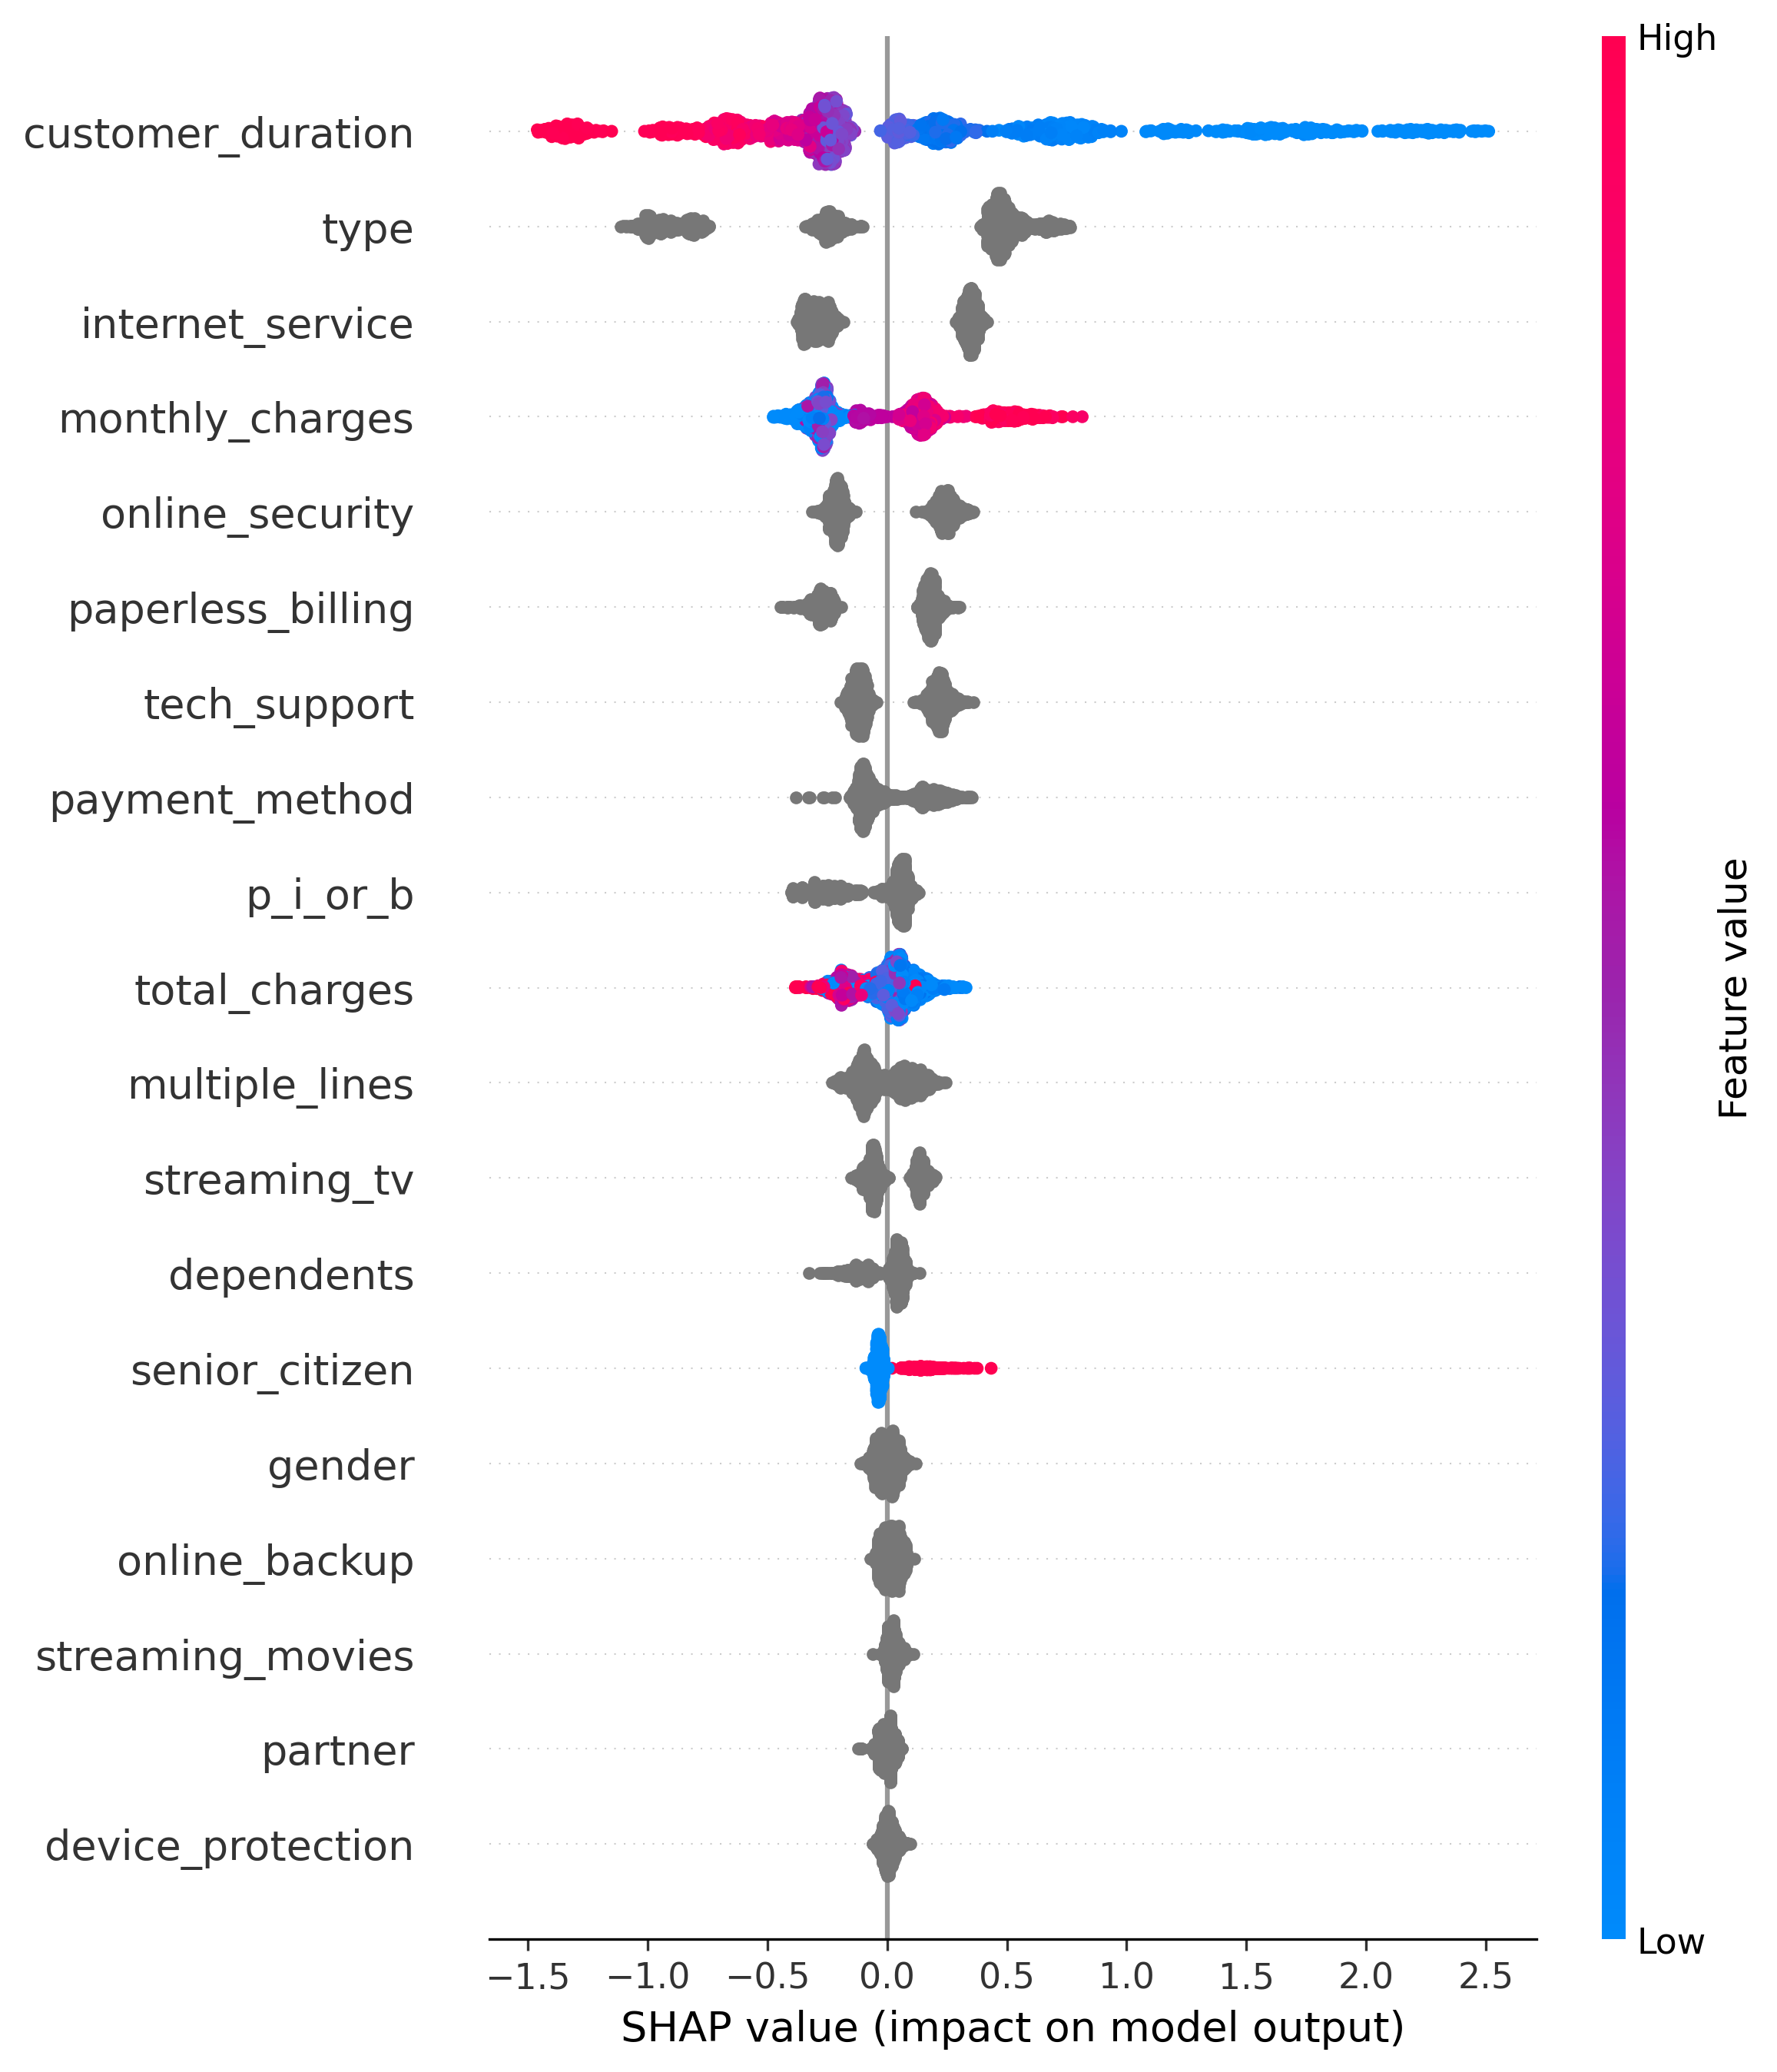

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.551299,0.222604,0.119619,0.264282,0.098567,0.033708,0.05403,0.023783,0.069023,0.098617,0.317771,0.228927,0.030432,0.01815,0.168881,0.093959,0.024845,0.094719,0.64163


In [7]:
display(Image(filename='cv_tuning_results/catboost_shap_summary_plot_fold1.png'))
cat_shap_fold_1

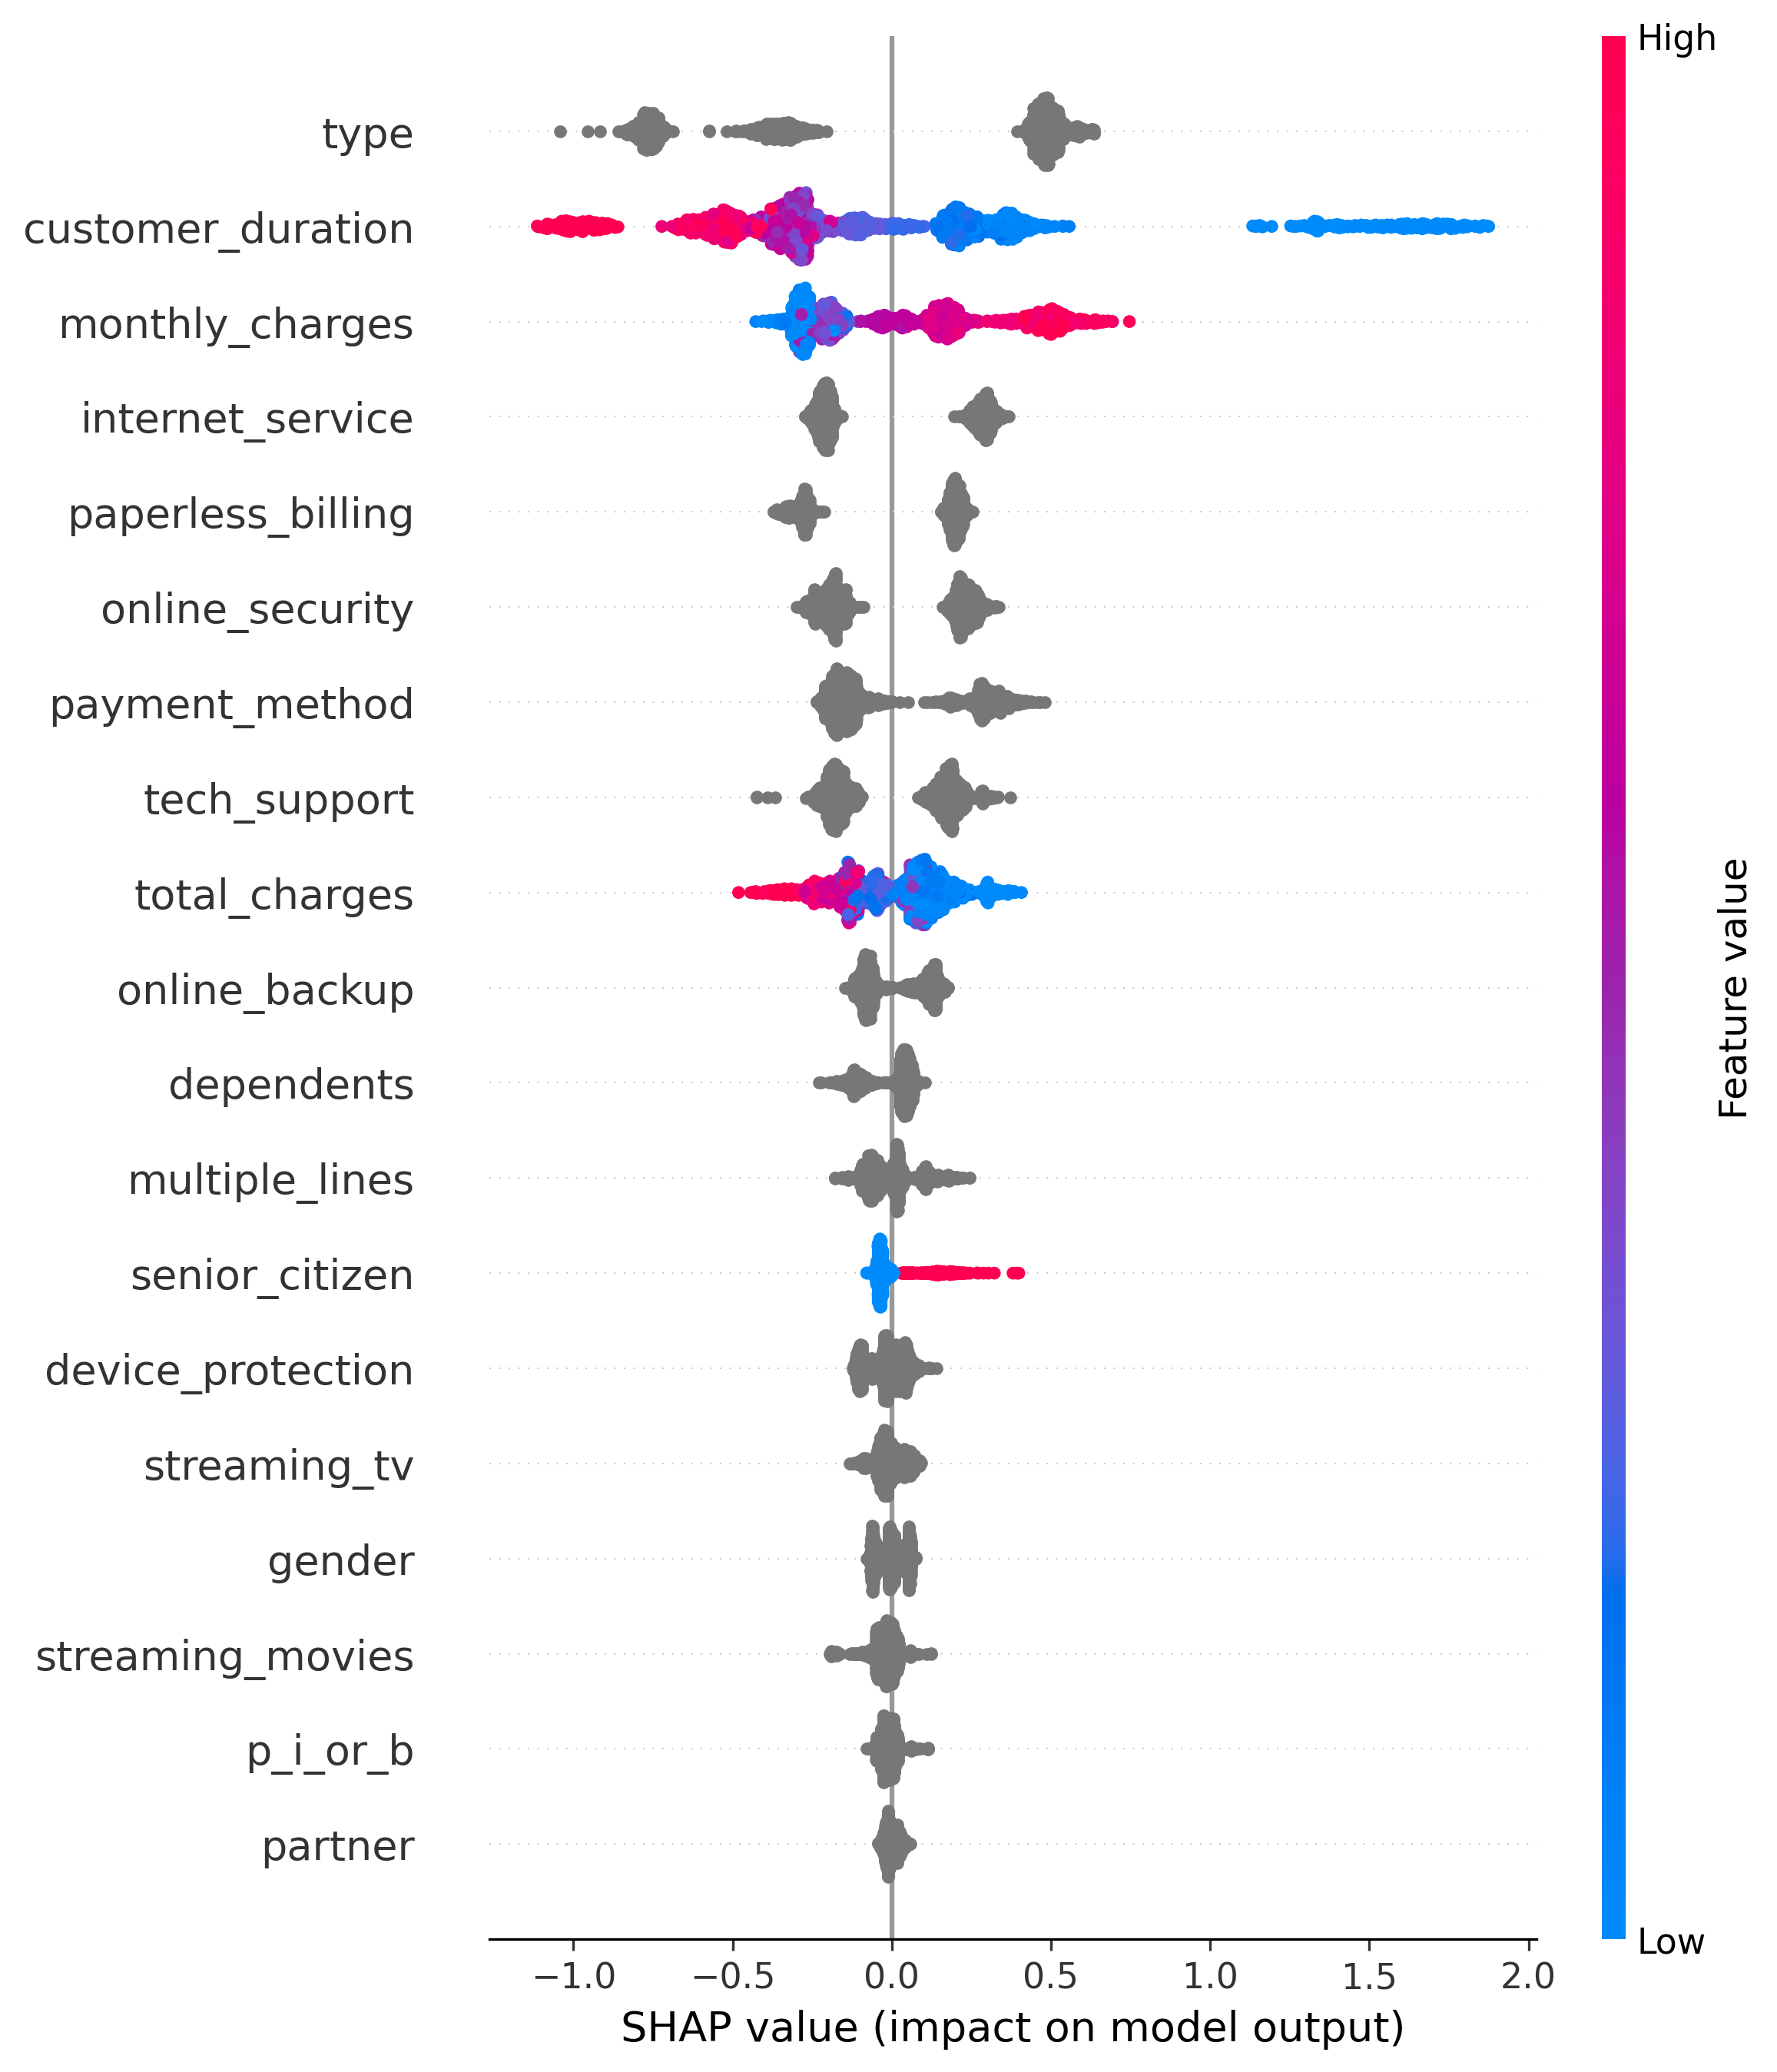

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.53116,0.235853,0.197888,0.265477,0.137859,0.032555,0.052931,0.015415,0.065253,0.017567,0.245393,0.213228,0.095287,0.042211,0.179839,0.033728,0.029014,0.060141,0.477388


In [8]:
display(Image(filename='cv_tuning_results/catboost_shap_summary_plot_fold2.png'))
cat_shap_fold_2

## LightGBM

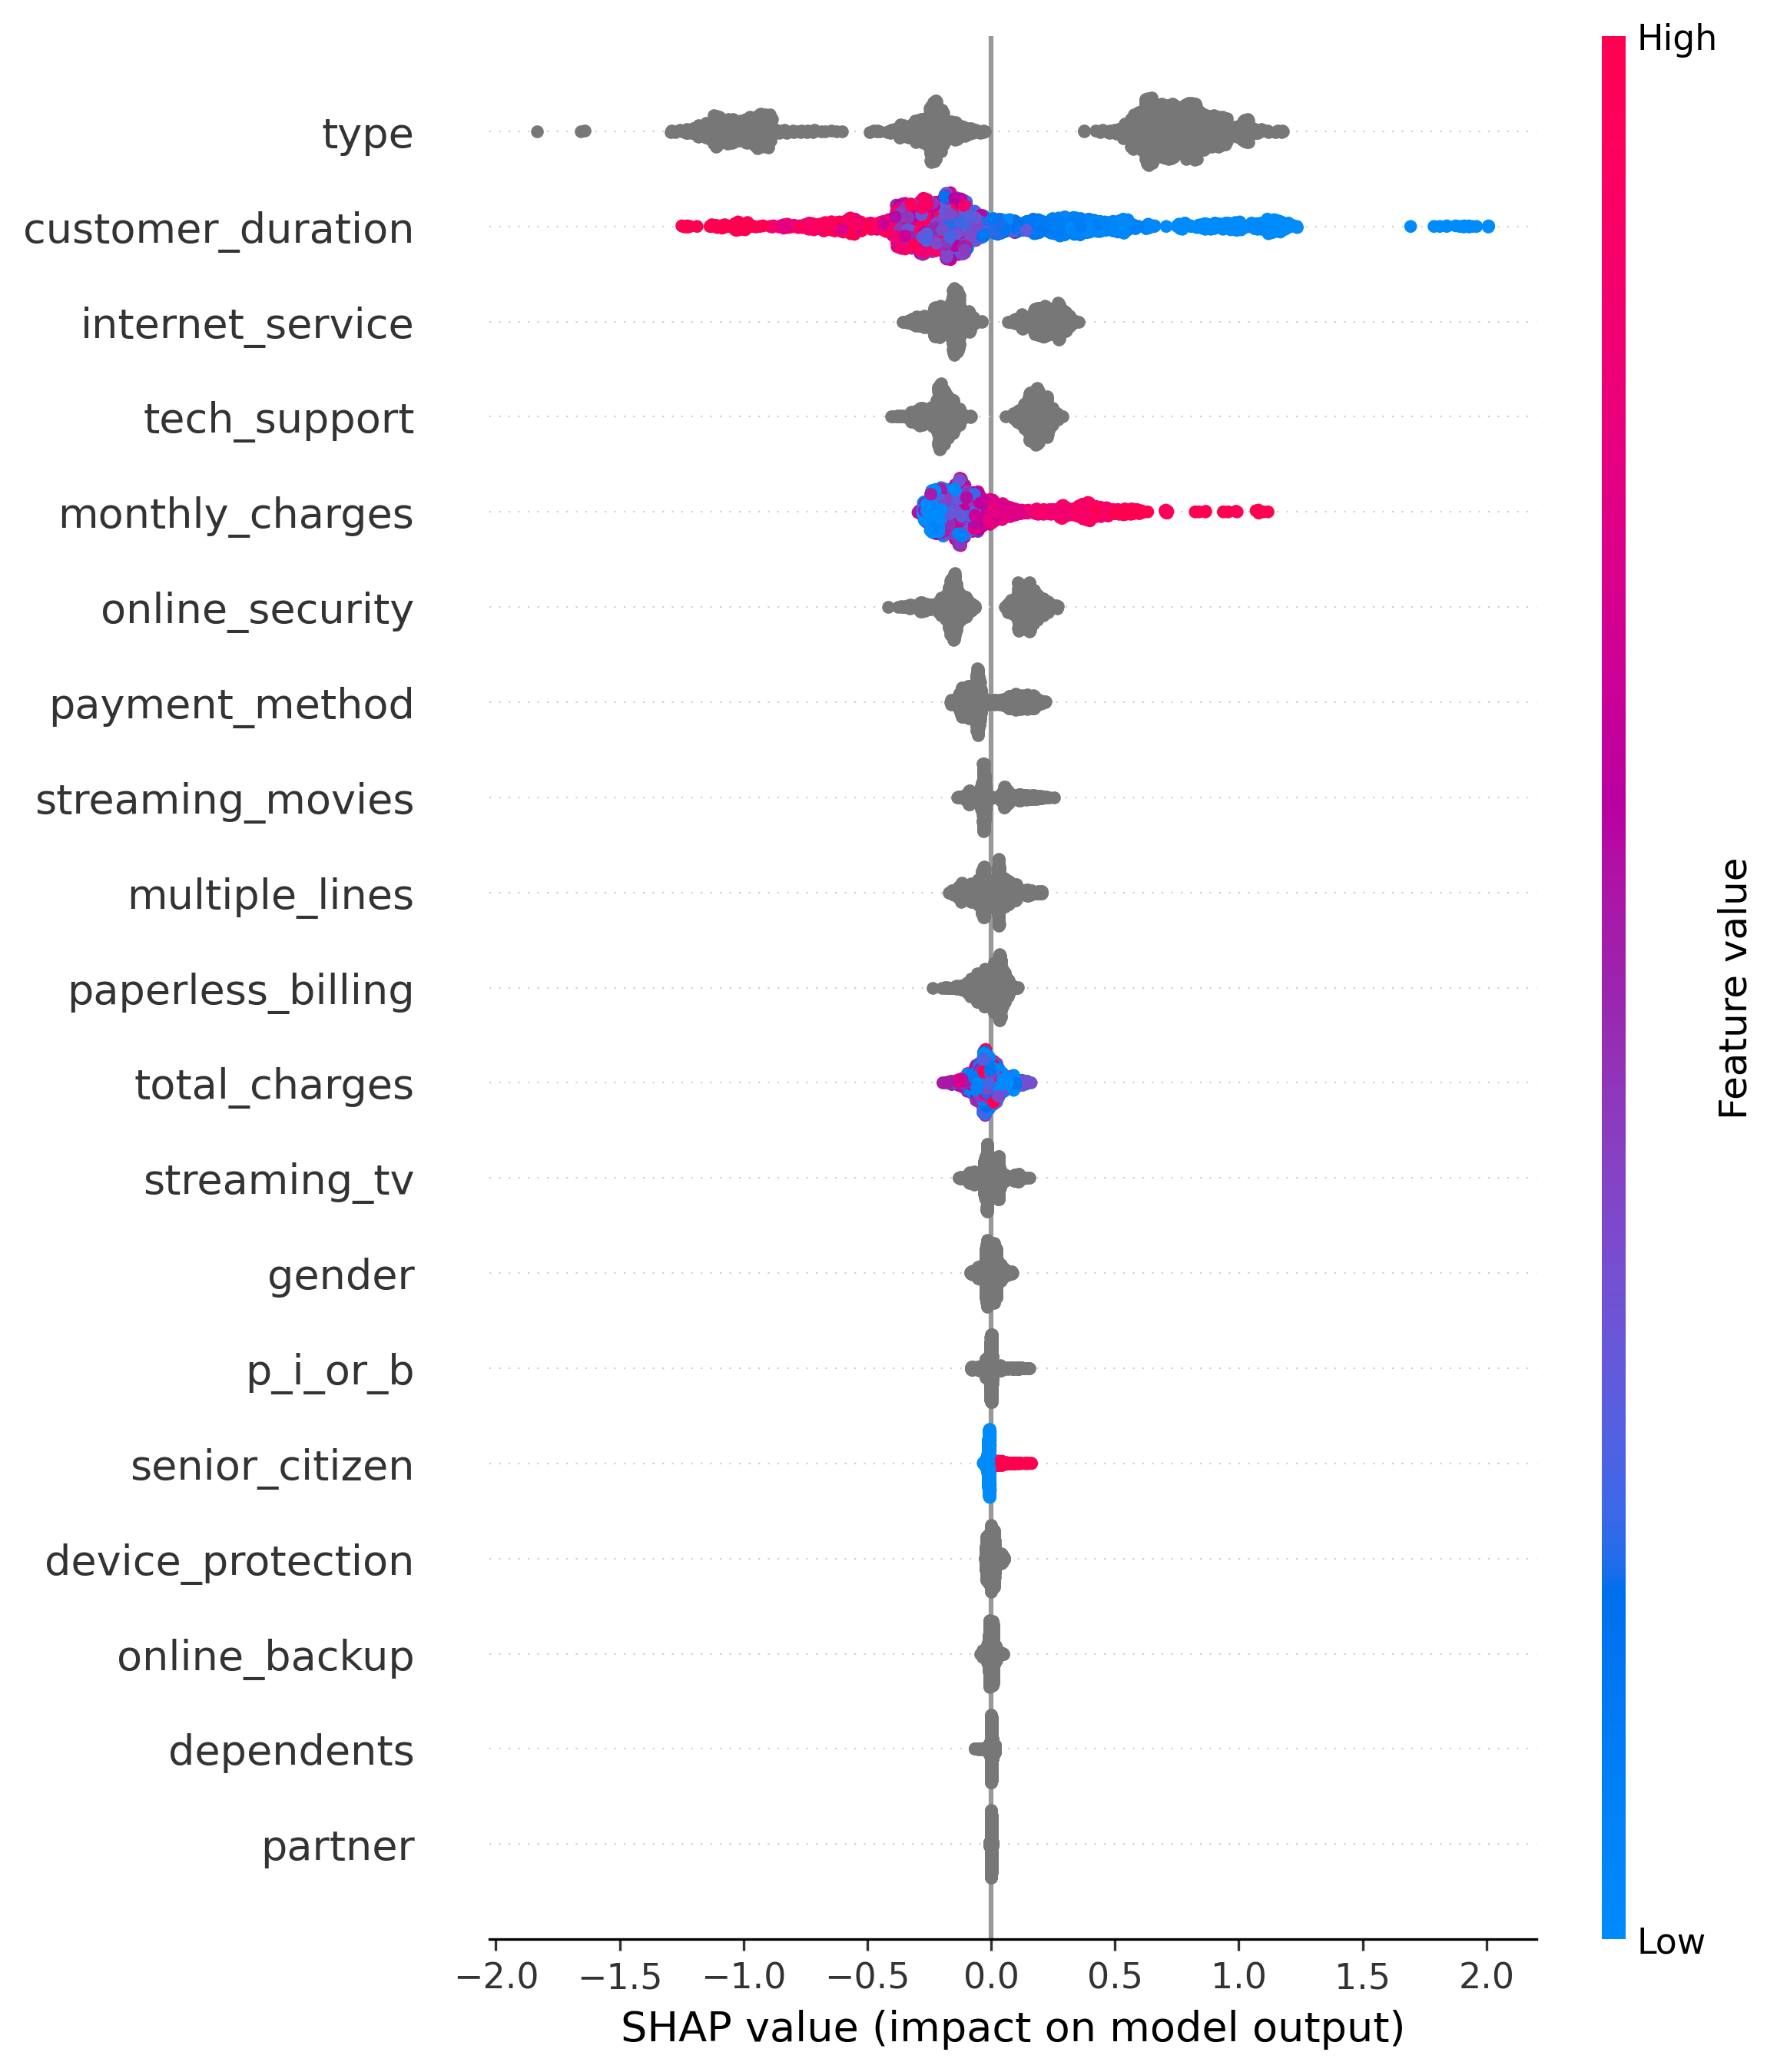

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.712314,0.04535,0.091193,0.194367,0.043983,0.021457,0.016557,0.001322,0.006739,0.018614,0.196606,0.15741,0.0099,0.013104,0.195969,0.04156,0.06594,0.063975,0.392539


In [9]:
display(Image(filename='cv_tuning_results/lightgbm_shap_summary_plot_fold0.png'))
lgbm_shap_fold_0

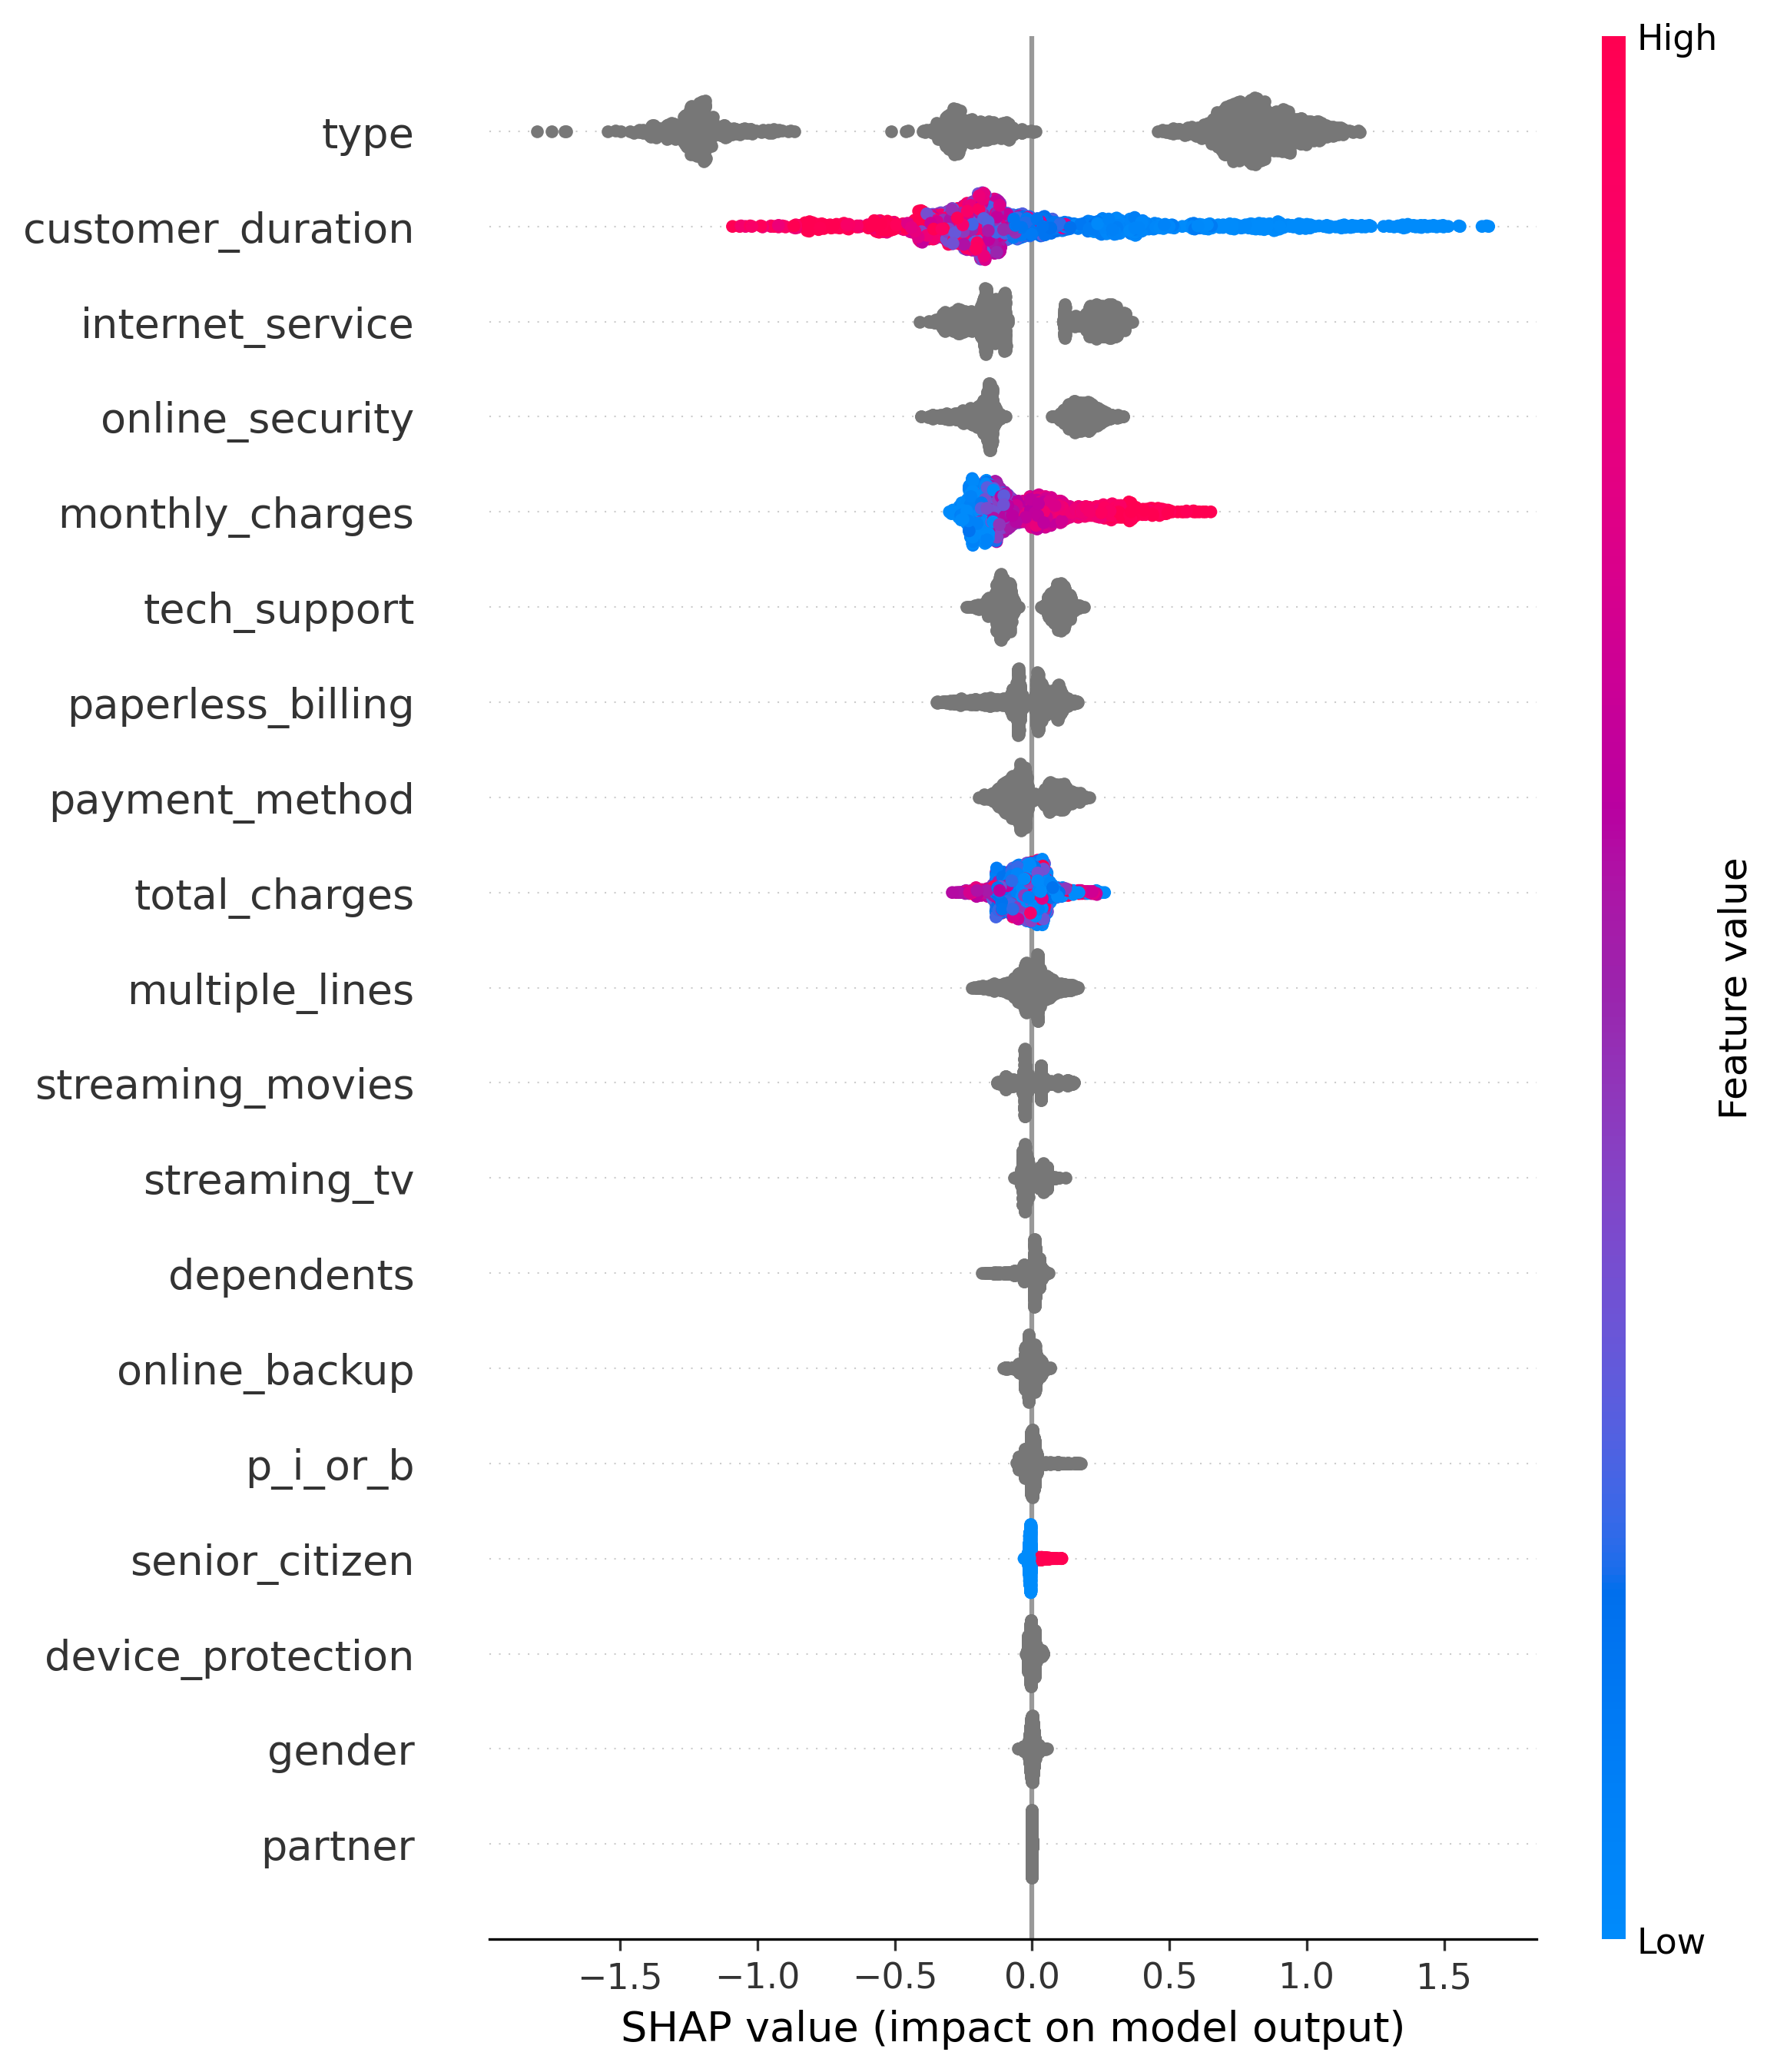

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.798485,0.080093,0.075465,0.16356,0.0639,0.008522,0.012078,0.000226,0.028009,0.017885,0.217592,0.189747,0.020372,0.008591,0.108744,0.031923,0.048337,0.059545,0.356299


In [10]:
display(Image(filename='cv_tuning_results/lightgbm_shap_summary_plot_fold1.png'))
lgbm_shap_fold_1

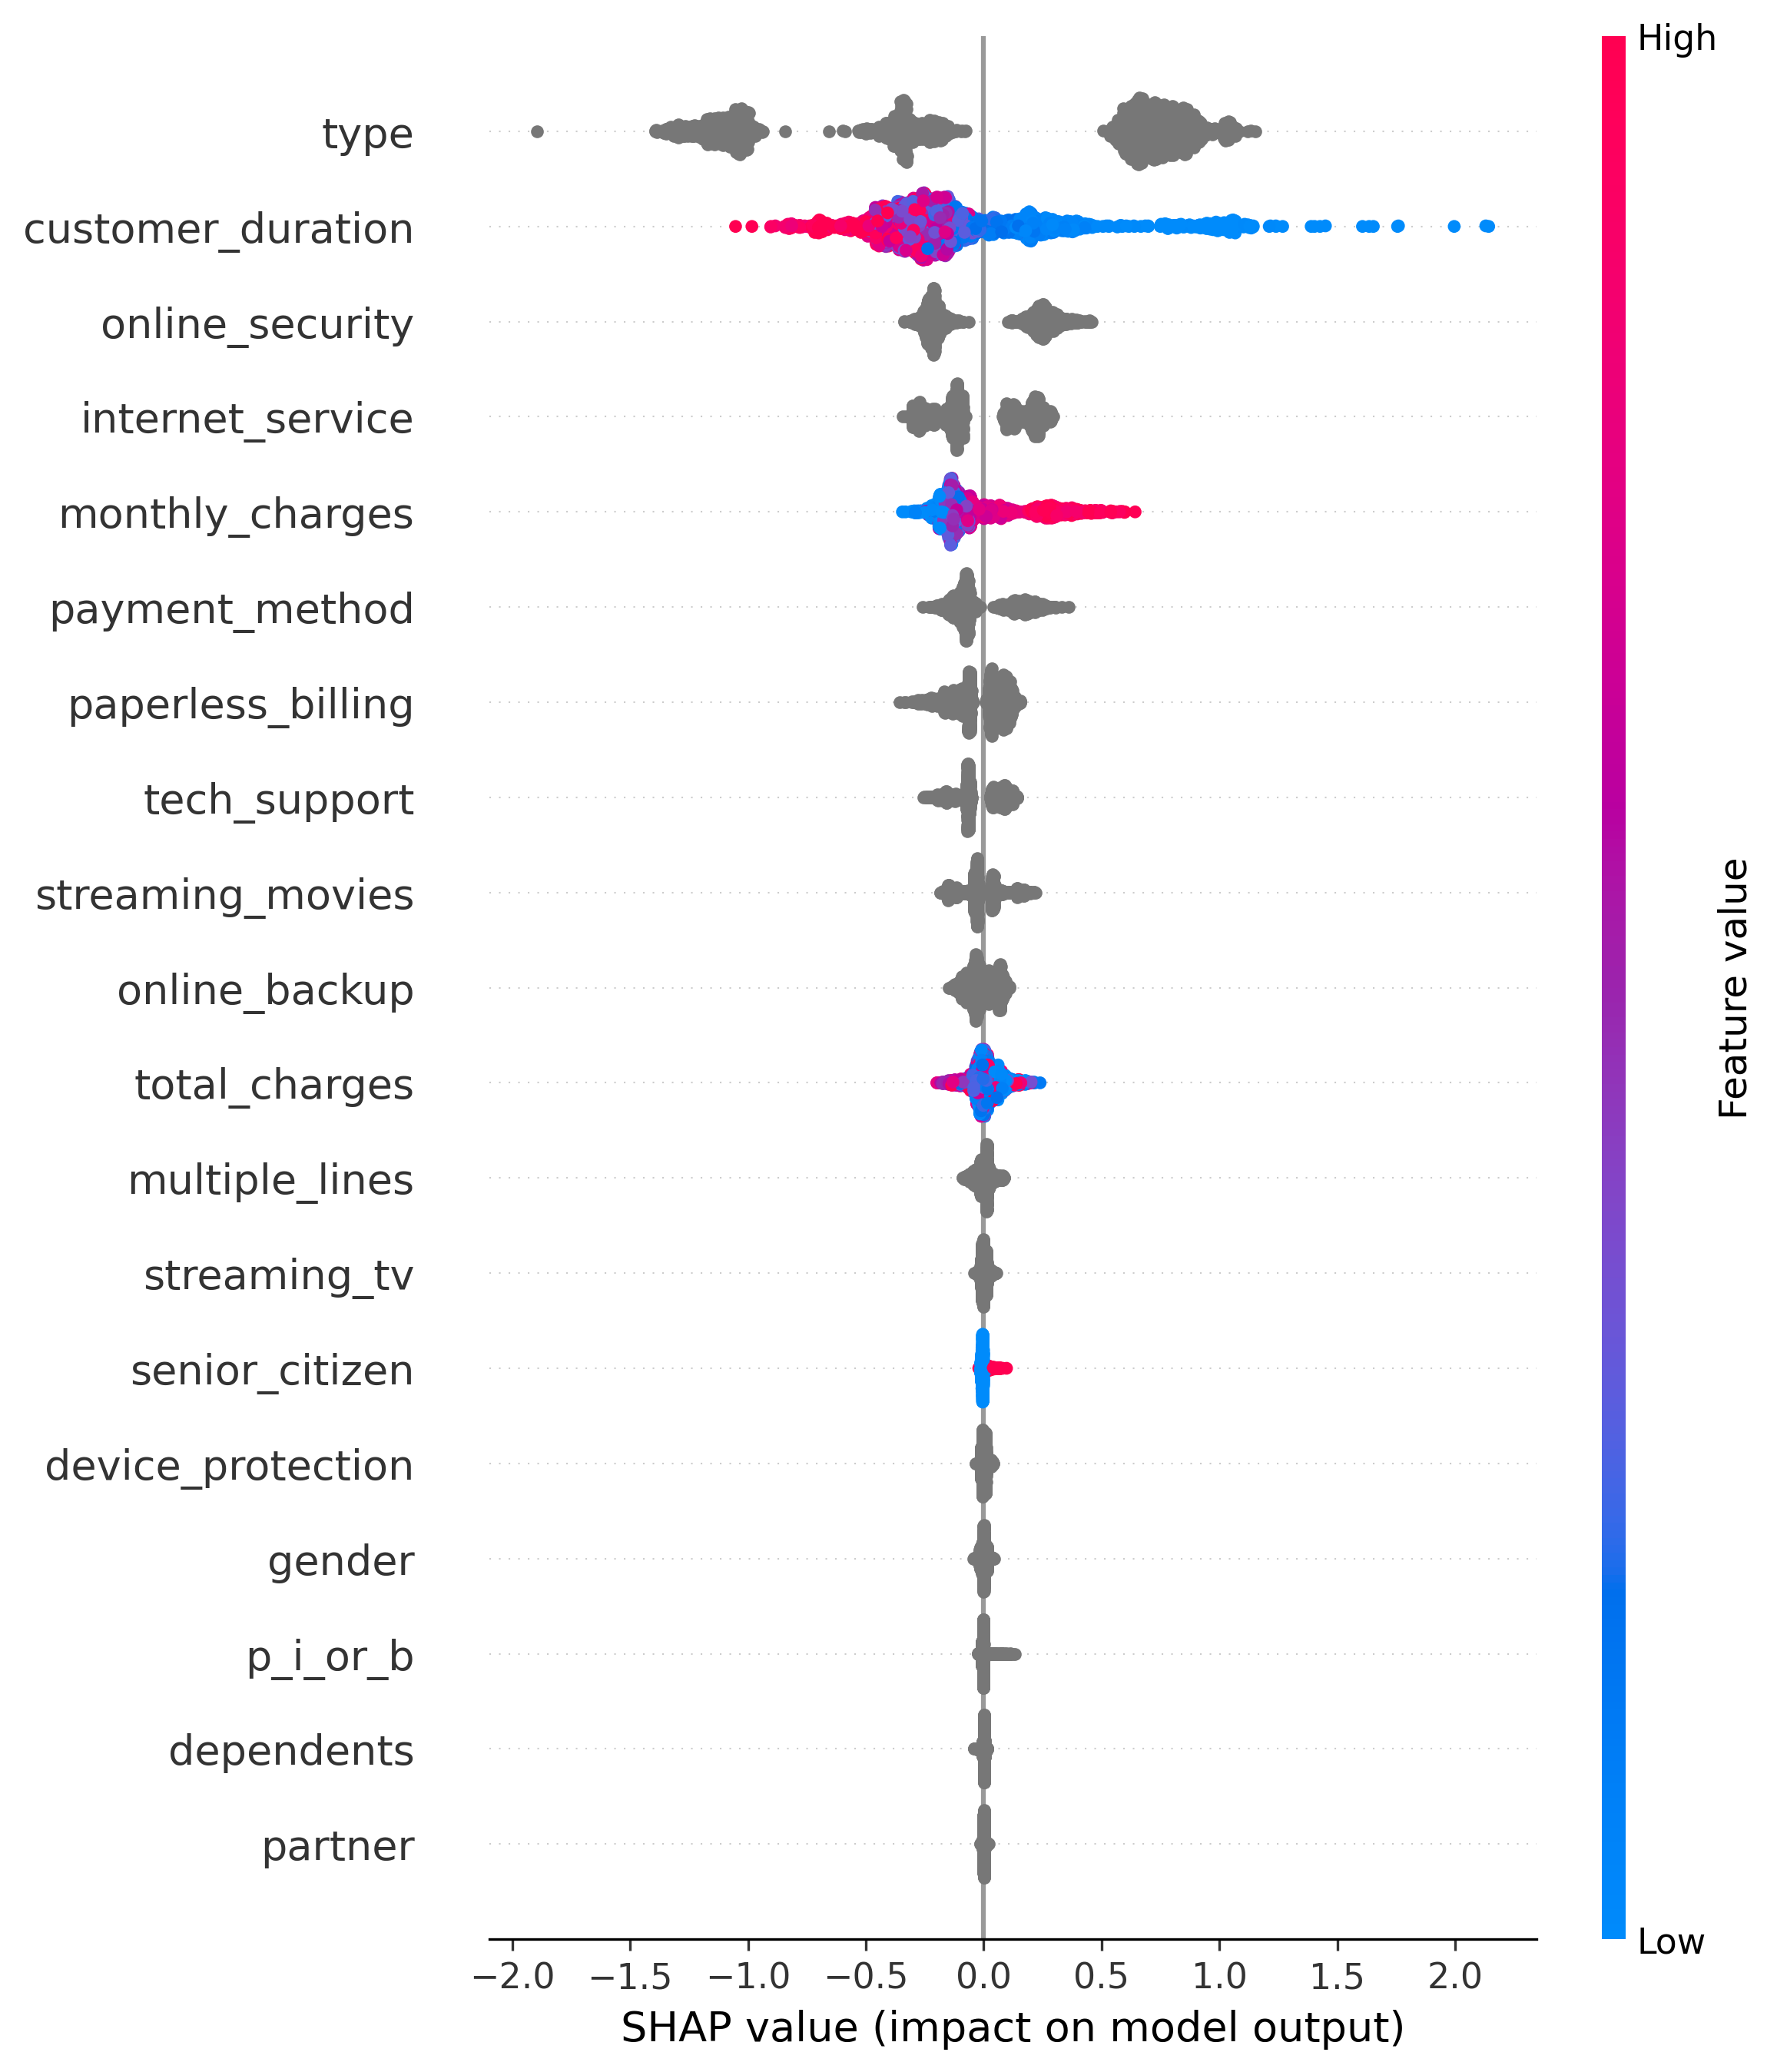

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.748424,0.092619,0.119759,0.159852,0.045729,0.007955,0.009687,0.002377,0.005433,0.007283,0.178904,0.235695,0.053844,0.008478,0.090685,0.010067,0.065353,0.029823,0.339733


In [11]:
display(Image(filename='cv_tuning_results/lightgbm_shap_summary_plot_fold2.png'))
lgbm_shap_fold_2

## XGBoost

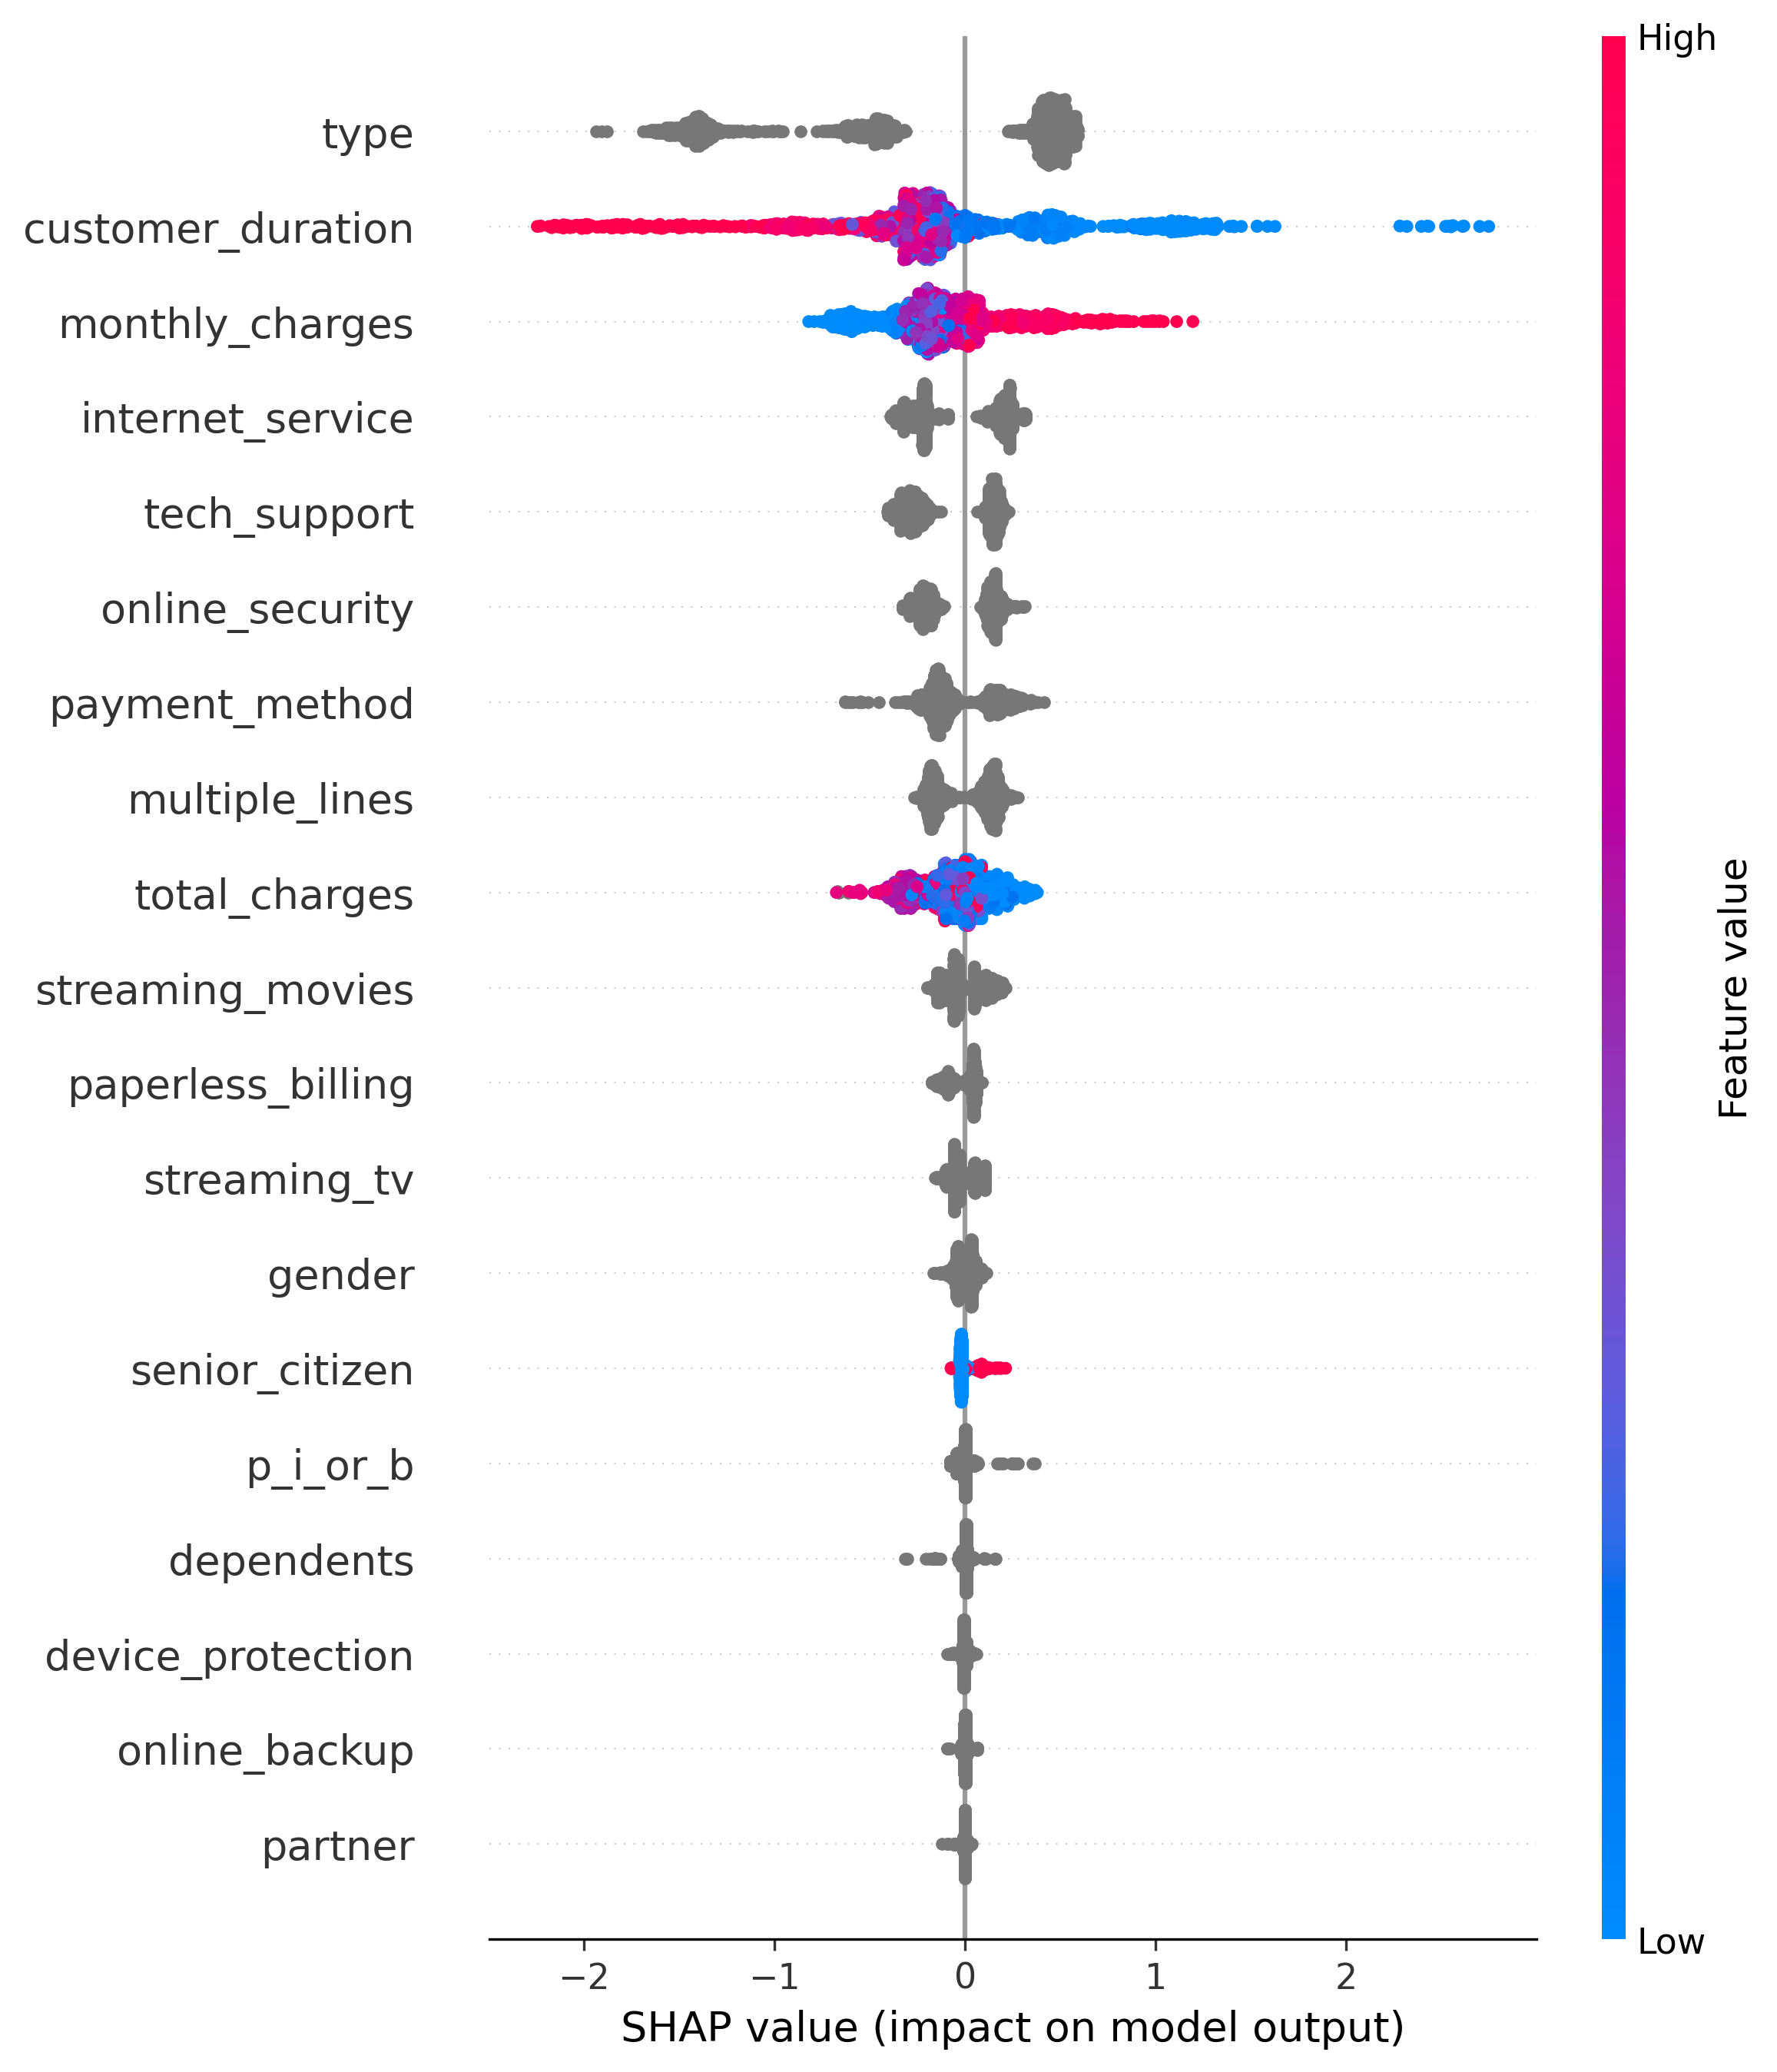

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.692891,0.063206,0.162145,0.258849,0.144586,0.046131,0.029849,0.004676,0.013812,0.021093,0.233802,0.183704,0.005024,0.013303,0.214727,0.056921,0.09013,0.150007,0.516972


In [12]:
display(Image(filename='cv_tuning_results/xgboost_shap_summary_plot_fold0.png'))
xgb_shap_fold_0

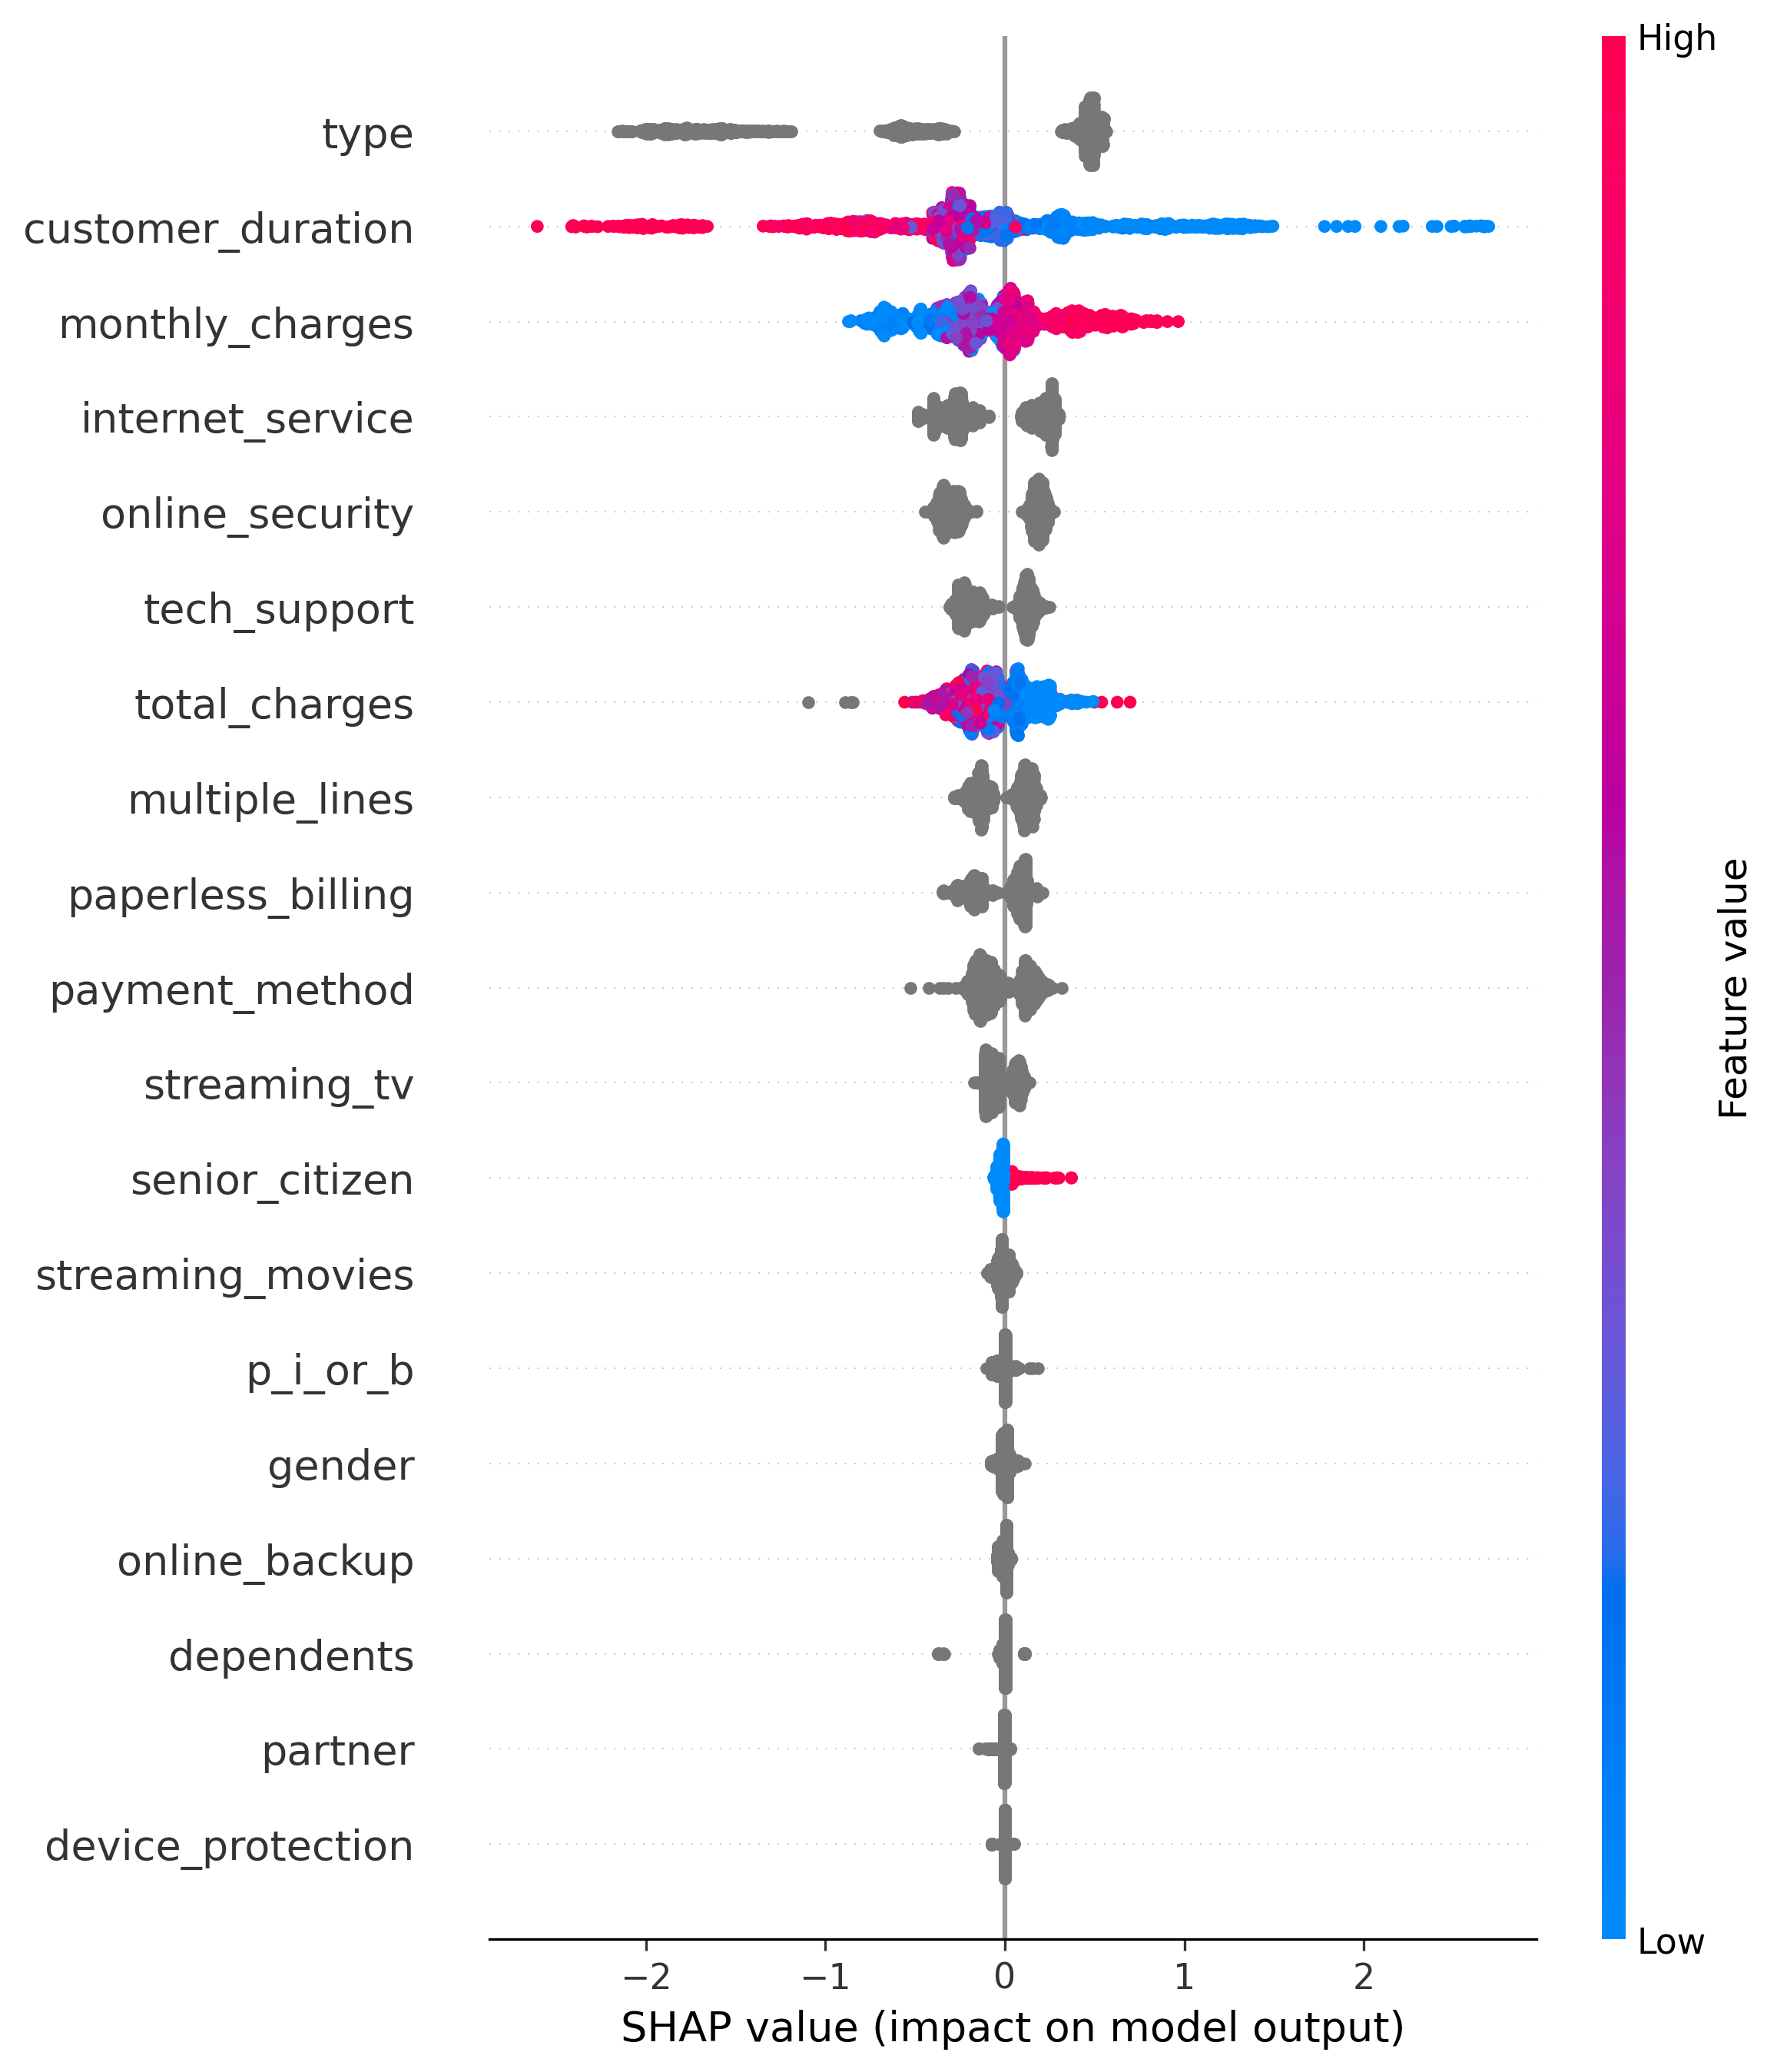

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.786007,0.130167,0.125613,0.277246,0.16267,0.01516,0.030053,0.005709,0.008454,0.017687,0.254015,0.24786,0.012853,0.002285,0.164989,0.075933,0.02962,0.132552,0.538373


In [13]:
display(Image(filename='cv_tuning_results/xgboost_shap_summary_plot_fold1.png'))
xgb_shap_fold_1

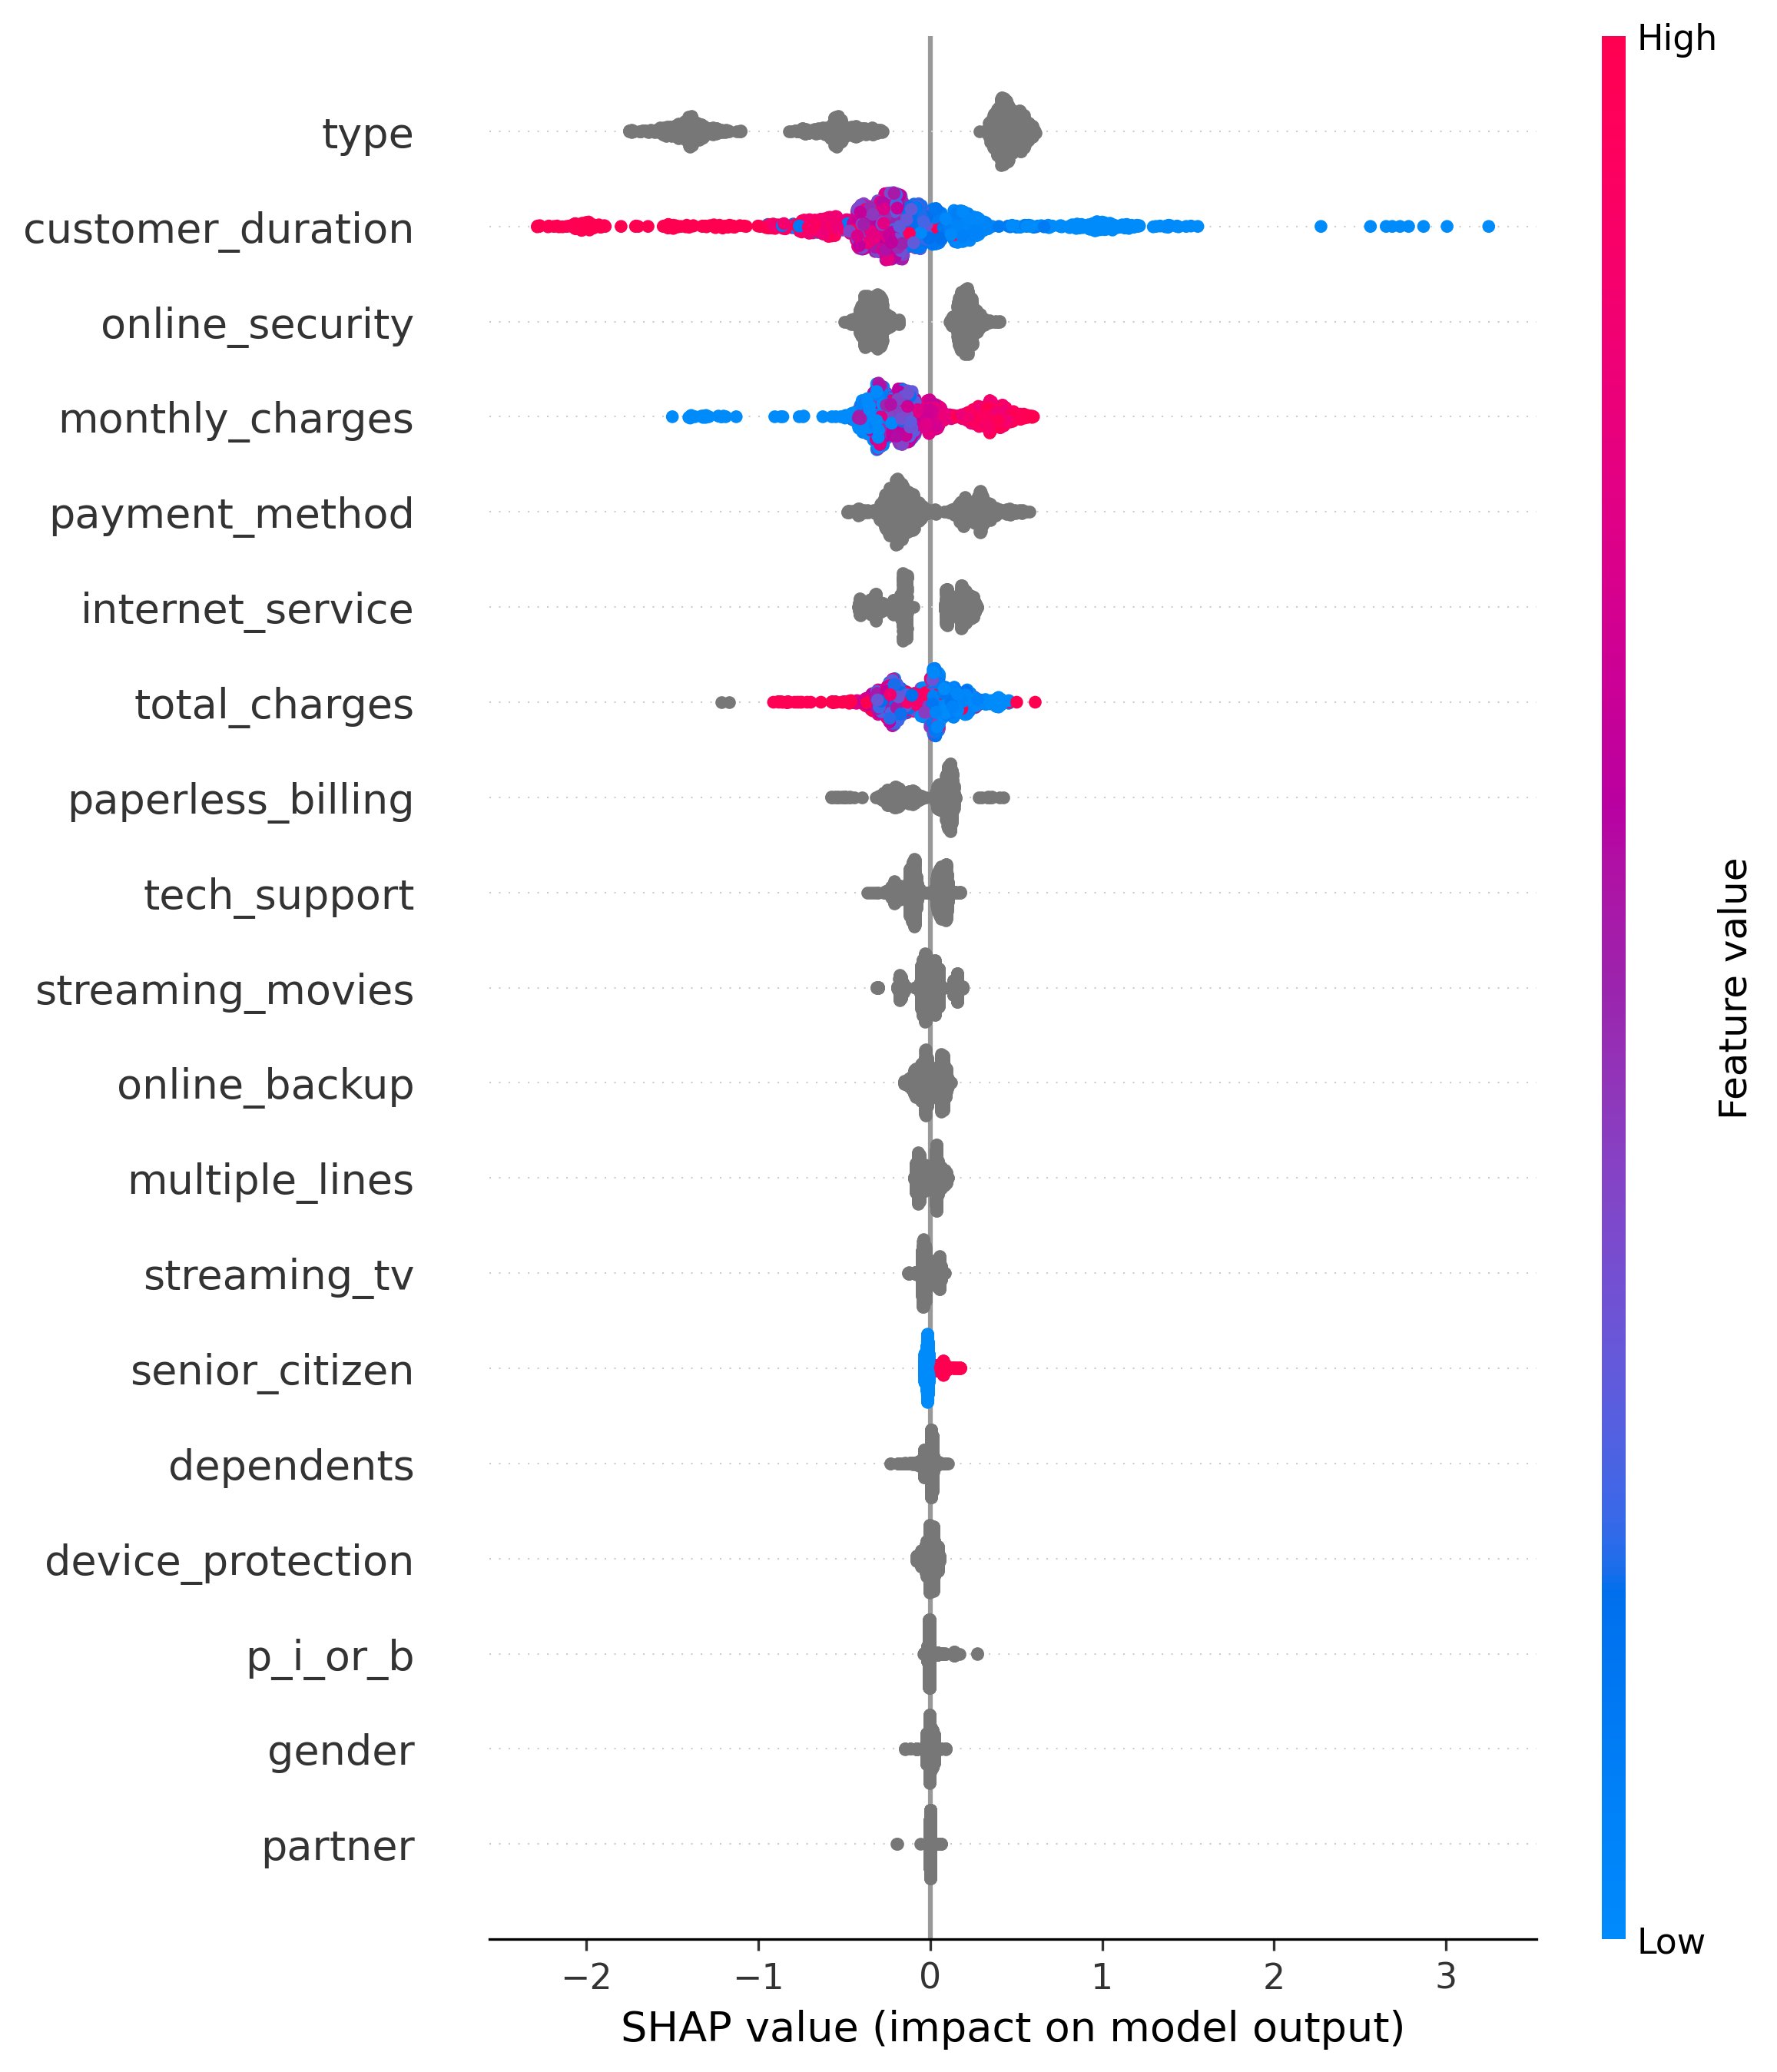

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,p_i_or_b,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,customer_duration
0,0.70934,0.133682,0.217787,0.253912,0.167937,0.011149,0.026211,0.002051,0.022928,0.014715,0.205711,0.275535,0.060142,0.02239,0.100853,0.041442,0.065436,0.051907,0.43477


In [14]:
display(Image(filename='cv_tuning_results/xgboost_shap_summary_plot_fold2.png'))
xgb_shap_fold_2

In [15]:
df_contract = pd.read_csv('contract.csv')
print(f"Earliest begin date {df_contract['BeginDate'].min()}")
print(f"Latest begin date  {df_contract['BeginDate'].max()}")

Earliest begin date 2013-10-01
Latest begin date  2020-02-01


In [16]:
df_contract['BeginDate'].dtype

dtype('O')

In [17]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['BeginDate'].dtype

dtype('<M8[ns]')

In [18]:
remainders = []

# We will use the combinations() method to avoid duplicate pairs
for i, j in combinations(df_contract['BeginDate'], 2):
    diff = abs((i -j).days)
    # Calculate remainders when all pair differences are divided by 30 
    remainder = diff % 30 # Each remainder can be thought of as the number of days a way from a 30 day interval to begin dates are 
    remainders.append(remainder)

counter = Counter(remainders)

top_20_modes = counter.most_common(20)

for i, (value, count) in enumerate(top_20_modes, 1):
    print(f"Mode {i}, value = {value}, count = {count}")
print(f"Mean distance from 30 day interval between start dates {np.mean(remainders)}")

Mode 1, value = 1, count = 1520762
Mode 2, value = 2, count = 1349327
Mode 3, value = 0, count = 1297883
Mode 4, value = 3, count = 1283110
Mode 5, value = 4, count = 1274833
Mode 6, value = 5, count = 1242797
Mode 7, value = 6, count = 1012156
Mode 8, value = 7, count = 943689
Mode 9, value = 10, count = 938834
Mode 10, value = 9, count = 917295
Mode 11, value = 8, count = 894765
Mode 12, value = 11, count = 828768
Mode 13, value = 14, count = 769806
Mode 14, value = 15, count = 769321
Mode 15, value = 16, count = 735290
Mode 16, value = 12, count = 726236
Mode 17, value = 13, count = 719815
Mode 18, value = 21, count = 680455
Mode 19, value = 19, count = 658862
Mode 20, value = 20, count = 640634
Mean distance from 30 day interval between start dates 11.720164076694777


Consistently, across all models and folds, the models relied most heavilyt on 'type' (contract_type) and 'customer_duration'. On the one hand this is not surprising: if a customer signed up for a two year plan, they are unlikely to terminate their membership with a customer_duration value equal to one year if they have already paid for the second year. Similarly, customers on a month to month membership are unlikely to terminate their membership in the middle of the month. Moreover, we would expect that each of our boosting models is able to discern this relationship with a fair degree of ease. For example, the model would be able to recognize that certain customer_duration lengths tend not to terminate their subscriptions when they have two year plans, and so on for different customer_duration lengths and other plan types. 

Given the dominance of 'customer_duration' and 'type' it might be reasonable to have some reamining worry about data leakage. We took some precautions on this point by subtracting a range of float values from 12-15 from the true customer_duration length. If we had not done this, and the 'customer_duration' feature had a length that was exactly aligned with the contract intervals provided by the 'type' feature this would constitute a kind of soft leakage. While every customer with such an alignment may not churn, the signal the model is picking up on would not be taking place until the date of the churn, and, therefore, would not be information the model would have prior to actual churn in a real world deployment setting. The truth is this picture is unrealistic because even though each subscription starts on the first of the month, the date range from October 1, 2013 to February 1, 2020 has enough variability in month lengths that the start dates do not occur at regular 30 day intervals.[^1] Perhaps a greater fear would be that the model could infer the start date of a given subscriber from the customer_duration and contract type. Translating the model's decision process into english, it might look something like "This customer has been a subscriber for this long. I see that there are a finite number of potential start and end date combinations (including the present date) which would yield this customer_duration. Now I can just see which such date combinations are consistent with the subscriber's contract type, and if the only options consistent with that contract type include an end date before the present, I know the customer has churned." This would be a strong instance of data leakage. However, by subtracting random float values between 12 and 15 from 'customer_duration' we prevent the soft leakage by ensuring any useful relationship between 'type' and 'customer_duration' is picked up by the model before the actual churn date, and we precent the hard leakage by making it immpossible for the model to triangulate on a start date based on customer_duration, because there is no way to deduce a finite number of potential date combinations for a given customer duration when the true customer duration is uncertain. While it is impossible to rule out with certainty the model's ability to find a way to cheat (after all you can't prove a negative) these are good reasons to think that our model will generalize well. 


[^1] In the previous code cell, we divided the difference between each start date from October 1, 2013 to February 1, 2020 by 30. We cut the quotient off at the integer and used the remainders to tell us how many days away from a thirty day interval the length between two begin dates is. We calculated modes 1-20 and the mean of the remainders for all begin date pairs in the data set. This means that we know how how far away from thirty day intervals the begin dates are on average, and the modes tell us that this average is not misleading. For example, if I were claiming there was enough variability in month lengths to prevent the model from knowledge of alignment between customer_duration and the ends of months, and the mean were 15, but all of the remainders were either 1 or 29, then the begin dates would actually align on roughly thirty day intervals even though the mean would suggest otherwise. Including the modes tells us whether or not the mean was representative. The results indicate that while the most common distance from a 30 day interval is 1 day, there are thousands of remainders between 5 and 20, meaning that the model would never be able to establish precise alignment between customer_duration and the end of a subscription. The best it could ever hope to do for month to month subscribers is say, based on the distances from 30 day intervals above, that a given customer is probably approaching the end of a subscription. Even if it could know this for certain it would not be data leakage. In fact, engineering an 'approaching_subscription_end' feature could be really useful.  

In [19]:

model_cat_roc_auc = joblib.load('cv_tuning_results/grid_search_cat.joblib').best_score_
model_light_roc_auc = joblib.load('cv_tuning_results/grid_search_light.joblib').best_score_
model_xgb_roc_auc = joblib.load('cv_tuning_results/grid_search_xgb.joblib').best_score_

model_cat_acc = joblib.load('cv_tuning_results/catboost_mean_accuracy.joblib')
model_cat_rec = joblib.load('cv_tuning_results/catboost_mean_recall.joblib')

model_light_acc = joblib.load('cv_tuning_results/lightgbm_mean_accuracy.joblib')
model_light_rec = joblib.load('cv_tuning_results/lightgbm_mean_recall.joblib')

model_xgb_acc = joblib.load('cv_tuning_results/xgboost_mean_accuracy.joblib')
model_xgb_rec = joblib.load('cv_tuning_results/xgboost_mean_recall.joblib')

C:\Users\Caitlin\Anaconda3\envs\sprint_17_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Caitlin\Anaconda3\envs\sprint_17_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Caitlin\Anaconda3\envs\sprint_17_env\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.

Let's get a look at the models' cross validation scores. Please note that the accuracy score and the optimal decision threshold (not show below) were calculated on a separate cv run from that of the roc_auc score. The roc_auc score for each model is the score for that model's best combination of hyperparameters during a grid search. The accuracy scores and optimal decision thresholds were calculated during a separate cv run with the tuned hyperparameters hard coded. 

In [20]:
print(f"model_cat roc_auc score: {model_cat_roc_auc}")
print(f"model_cat accuracy score: {model_cat_acc}")
print(f"model_cat recall score: {model_cat_rec}\n")

print(f"model_light roc_auc score: {model_light_roc_auc}")
print(f"model_light accuracy score: {model_light_acc}")
print(f"model_light recall score: {model_light_rec}\n")

print(f"model_xgb roc_auc score: {model_xgb_roc_auc}")
print(f"model_xgb accuracy score: {model_xgb_acc}")
print(f"model_xgb recall score: {model_xgb_rec}\n")

model_cat roc_auc score: 0.84971210789287
model_cat accuracy score: 0.8065317713880015
model_cat recall score: 0.5277985690256014

model_light roc_auc score: 0.8502556088408536
model_light accuracy score: 0.8049343272985445
model_light recall score: 0.4889953937325789

model_xgb roc_auc score: 0.8521675316632434
model_xgb accuracy score: 0.7165424210152644
model_xgb recall score: 0.8521997140197396



Okay, model_xgb slightly outperformed the other models in roc_auc during cross validation, but the model_cat and model_light outperformed model_xgb in accuracy by a wide margin. Our code is set to select the best performing model according to roc_auc by default. This is justified due to the class imbalance which is roughly 75% negative class values to 25% positive class values (see the EDA). A class imbalance of this magnitude means that a high accuracy score can be misleading: the model may not be picking up on a lot of signal, it may just be choosing to predict the majority class the majority of the time. With roc_auc scores hovering around .85 this is unlikely to be the case for any of the models, as roc_auc measures the rate of true positives meaning each of the models' positive classifications were correct ~85% of the time. This ratio would be impossible to acheive if the models were simply predicting the dominant class the majority of the time without picking up on signal. With all that said, there may be a justification for overriding the default selection of the model with the highest roc_auc score during cross validation. 

However, having run multiple cv iterations with the same parameter grids, I can say that this was the closest roc_auc comparison of all of the cv runs I did as I put the project together. Typically, model_xgb outpeformed the other two by about .02 or .03. Moreover, we calculated the optimal decision threshold with youden's J statistic and applied it to the model's test set predictions. Recall is also an important metric here, as a lost customer will be a much larger revenue hit than providing an unnecessary sales promotion, and by this metric, model_xgb outperforms model_light and mode_cat by a wide margin. With all of these things considered, the model_xgb is the right choice for the job. 

In [21]:
test_results = pd.read_csv('test_results/test_scores.csv')
test_results

,Unnamed: 0,roc_auc,accuracy_score,recall_score
0,0,0.869902,0.765791,0.807487


In [22]:
opt_thresh_xgb = joblib.load('cv_tuning_results/xgboost_optimal_threshold.joblib')
opt_thresh_xgb

np.float32(0.6043288)

Having trained on the full data set, we got a mild improvement in roc_auc over the cross validation score which is to be expected. We also got a substantial improvement in accuracy over and above the accuracy score during cross validation. This likely results from the adjustment to the optimal threshold which optimizes for the best balance between the rate of true positives and the rate of true negatives. As you can see, for model_xgb the proper decision threshold (youden's j) is 0.6 which means model_xgb's optimal balance between true positive rate and true negative rate actually occrus when it is less likely to make a positive prediction (> 0.6 vs > 0.5). 

Given the task at hand, it would arguably be best to go withthe original model, as losing 5% more customers to churn is likely less costly than making unnecessary promotional offers to 5 percent more customers (roughly the difference between the cv accuracy score and the test accuracy score.) There is no guaruntee that all of the increased accuracy is due to a decrease in false positive rate and an increase in true negative rate. However, based on the fact that we set the decision threshold so that churn predictions are less common and our recall score dropped 5 percent from cross validation to testing, it is a fair bet that the majority of accuracy improvement came from converting false positives into true negatives. The print_save_metrics function in model_utils.py has an ignore_youden_j parameter that is set to False by default. I tried a test run with ignore_youden_j set to True, and the resulting recall score was 0.89.  We did not perform a cross validation step with the optimized decision threshold and without it, so we cannot confidently say that a recall difference of this magnitude would generalize. However, the fact that the optimized threshold makes the prediction of the positive class less likely makes it reasonable to presume the default threshold model would have an impactful recall advantage that does indeed generalize. All things being equal, I would reccomend that interconnecct use the default threshold model_xgb. I only utilized the results from the optimized threshold here because it made for a more interesting analysis. 

## Summary and Conclusions

We took extra precautions to prevent data leakage. Subtracting a range of frandom float values from 12-15 may have even been overkill given the number number of remainder values. without being able to know with certainty that a given customer_duration is nearing the end of a subscription, there would be many date combinations that would likely be compatible with the contract type, and it would be likely that many of them would not indicate that a churn took place. 

One potential improvement would be engineering an 'approaching_subscription_end' feature. Of course, this would definitely require that we maintain the range of 3 random float values for the value we subtract from the true customer_duration as engineering such a feature would likely improve the model's ability to triangulate on a start date by a significant degree. 

We ended up choosing model_xgb over model_light and model_cat despite its significantly lower accuracy scores because the roc_auc's were roughly even, and recall is a much more important metric for the task at hand than accuracy scores are. We also noted that the Youden's J thershold adjustment may be undesireable for our task. If we wanted to be rigorous, we should probably run another cross validation comparing the recall scores of our chosen model with an optimal threshold versus non-optimmal threshold. However, there are good a-priori reasons for believing the non-optimal threshold would produce a better recall score on any novel data set. Therefore, in case we wanted to do this, I added an 'ignore_youden_j' parameter to the print_and_save metrics function in model_utils.py. I also added an override parameter to the model_selection function in model_utils, which can be utilized any time the user does not agree with the hard coded model selection criteria. 